In [1]:
import pdf
import util
import os
import chunking
import vector_store as vs
from tqdm import tqdm
from langchain_qdrant import FastEmbedSparse
from langchain_openai import OpenAIEmbeddings
import api
import retrieval
import chatbot
import re
from IPython.display import Image, display
import evaluation as eval
import json

/Users/lucachangretta/opt/anaconda3/envs/Thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

pdf_paths = ["Dataset/File1_manual.pdf", "Dataset/File2_manual.pdf", "Dataset/File3_manual.pdf", "Dataset/File4_manual.pdf"]
query_path = "query.txt"

individual_pages_folder = 'manual_individual_pages'
all_contents_folder = 'manual_all_contents'

text_collection_name = 'manual_texts_no_diff'
caption_collection_name = 'manual_captions_no_diff'

# Extract Content

In [ ]:
util.clear_folder(individual_pages_folder)
util.clear_folder(all_contents_folder)

for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.extract_pages()
    all_texts = file.combine_pages_txt()

    # Extract single pages
    image_save_dir = f"{all_contents_folder}/{file.name}/Images"
    os.makedirs(image_save_dir, exist_ok=True)
    for page in file.pages:
        page.text = page.text.split('Differential Diagnosis')[0]
        page_text_save_dir = f"{individual_pages_folder}/{file.name}"
        os.makedirs(page_text_save_dir, exist_ok=True)
        util.save_text_to_file(page.text, f"{page_text_save_dir}/Page{page.page_num+1}.txt")
        for image in page.images:
            image_save_path = f"{image_save_dir}/Page{image.parent_page_num+1}_Figure{image.index+1}.{image.ext}"
            image.save(image_save_path)
            image.path = image_save_path

    # Save combined texts
    all_texts_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(all_texts_save_dir , exist_ok=True)
    util.save_text_to_file(all_texts, f"{all_texts_save_dir}/{file.name}.txt")

    # Save all the images info
    images_info_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(images_info_save_dir, exist_ok=True)
    file.save_images_info(f"{images_info_save_dir}/Images_info.json")


manual_individual_pages is ready for new content.
manual_all_contents is cleared!
manual_all_contents is ready for new content.


Processing pages of file Dataset/File1_manual.pdf: 100%|██████████| 2/2 [00:00<00:00, 86.61it/s]


Saved content to manual_all_contents/File1_manual/Images_info.json


Processing pages of file Dataset/File2_manual.pdf: 100%|██████████| 16/16 [00:00<00:00, 140.67it/s]


Saved content to manual_all_contents/File2_manual/Images_info.json


Processing pages of file Dataset/File3_manual.pdf: 100%|██████████| 59/59 [00:00<00:00, 631.90it/s]


Saved content to manual_all_contents/File3_manual/Images_info.json


Processing pages of file Dataset/File4_manual.pdf: 100%|██████████| 23/23 [00:00<00:00, 660.22it/s]

Saved content to manual_all_contents/File4_manual/Images_info.json


# Pair Captions

In [3]:
for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.images = util.create_class_from_json(pdf.Image, f"{all_contents_folder}/{file.name}/Images_info.json")
    for image in file.images:
        txt_path = f"{individual_pages_folder}/{file.name}/Page{image.parent_page_num+1}.txt"
        image.pair_caption(txt_path)

    images_info_save_dir = f"{all_contents_folder}/{file.name}"
    os.makedirs(images_info_save_dir, exist_ok=True)
    file.save_images_info(f"{images_info_save_dir}/Images_info.json")

Saved content to manual_all_contents/File1_manual/Images_info.json
Saved content to manual_all_contents/File2_manual/Images_info.json
Saved content to manual_all_contents/File3_manual/Images_info.json
Saved content to manual_all_contents/File4_manual/Images_info.json


# Generate & Save Embeddings

In [4]:
chunks = []
images = []

for pdf_path in pdf_paths:
    file = pdf.PDF(pdf_path)
    file.images = util.create_class_from_json(pdf.Image, f"{all_contents_folder}/{file.name}/Images_info.json")
    
    chunk_with_paths = chunking.single_page_chunk(f"{individual_pages_folder}/{file.name}")
    for item in chunk_with_paths:
        chunks.append(chunking.Chunk(item[0], item[1]))

    for image in file.images:
        images.append(image)

vs.create_collection(text_collection_name, 1536)
vs.create_collection(caption_collection_name, 1536)

for chunk in tqdm(chunks, desc="Adding text cunks to the vectore store."):
    vs.add_txt(text_collection_name, chunk)
for image in tqdm(images, desc="Adding captions to the vectore store."):
    vs.add_image(caption_collection_name, image)

Collection manual_texts_no_diff initialized.
Collection manual_captions_no_diff initialized.


Adding captions to the vectore store.: 100%|██████████| 97/97 [01:57<00:00,  1.21s/it]


# Query Enrichment

In [3]:
def query_enrichment(
        query, 
        text_collection_name, 
        txt_similarity_topk
    ):
    
    dense_embedding_function = OpenAIEmbeddings(api_key=api.OPENAI_KEY, model="text-embedding-3-small")
    sparse_embedding_function = FastEmbedSparse(model_name="prithivida/Splade_PP_en_v1")
    
    collection_text = vs.get_collection(
        text_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    text_retriever = retrieval.Retriever(query, collection_text)
    text_retriever.similarity_search(txt_similarity_topk)

    context = " "
    context_indices = []
    for doc in text_retriever.found_docs:
        payload = vs.retrieve_payload(doc, collection_text)
        context += payload.get('content', "")
        context_indices.append(payload.get('index'))

    response = chatbot.query_enrichment(query, context)

    return response

# Respond to a Query

In [9]:
def respond(
        query, 
        text_collection_name, 
        caption_collection_name, 
        txt_similarity_topk, 
        image_similarity_topk, 
        verbose=1):
    
    dense_embedding_function = OpenAIEmbeddings(api_key=api.OPENAI_KEY, model="text-embedding-3-small")
    sparse_embedding_function = FastEmbedSparse(model_name="prithivida/Splade_PP_en_v1")
    
    collection_text = vs.get_collection(
        text_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    collection_caption = vs.get_collection(
        caption_collection_name, 
        dense_embedding_function,
        sparse_embedding_function
    )

    text_retriever = retrieval.Retriever(query, collection_text)
    text_retriever.similarity_search(txt_similarity_topk)

    context = " "
    context_indices = []
    for doc in text_retriever.found_docs:
        payload = vs.retrieve_payload(doc, collection_text)
        context += payload.get('content', "")
        context_indices.append(payload.get('index'))

    new_query = query_enrichment(query, text_collection_name, 3)
    response = chatbot.disease_list_prediction(new_query, context)
    pattern = r'(Disease name \d+:\s*.*?)(?=Disease name \d+:|$)'
    predictions = re.findall(pattern, response, flags=re.DOTALL)

    image_paths = []
    for prediction in predictions:
        image_retriever = retrieval.Retriever(prediction, collection_caption)
        image_retriever.similarity_search(image_similarity_topk)
        retrieved_image = image_retriever.found_docs[0]
        image_payload = vs.retrieve_payload(retrieved_image, collection_caption)
        image_path = image_payload["path"]
        image_paths.append(image_path)
        if verbose:
            print(prediction)
            display(Image(filename=image_path))

    return predictions, image_paths, context, context_indices

Disease name 1:Central giant cell granuloma:Disease 1 description: It is often found in young individuals and appears in the body of the mandible as a unilocular radiolucency in early stages. It can cause considerable bone expansion and potential effects on adjacent teeth such as displacement and root resorption. Although it typically becomes multilocular, early unilocular appearances with defined but non-corticated borders could align with the given case.




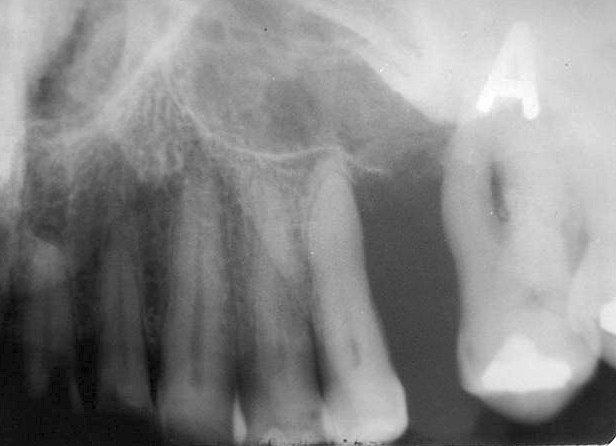

Disease name 2:Simple bone cyst:Disease 2 description: Appears as an asymptomatic radiolucency in the mandible with defined but not corticated borders, often not associated with tooth origins and may cause tooth displacement. It is a single lesion, which aligns with the case scenario of a unilocular, radiolucent lesion with cortical expansion and root resorption.




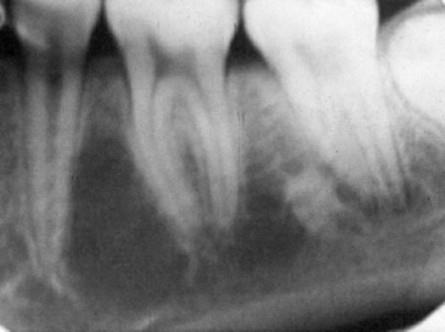

Disease name 3:Radicular cyst:Disease 3 description: While usually associated with non-vital teeth, it is a common radiolucent finding and could present as a defined unilocular lesion that may cause expansion and tooth displacement. In this case, it may mimic similar traits even if the classical association with non-vital teeth is not evident, due to the displacement and size of the lesion.


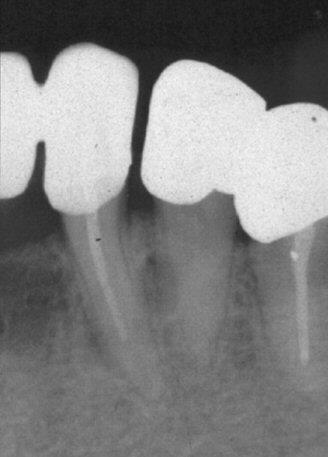

In [6]:
query = util.read_query(query_path).replace('\n', "").strip()
predictions, image_paths, context, context_indices = respond(query, text_collection_name, caption_collection_name, 3, 1)

In [8]:
print(context_indices)

['manual_individual_pages/File3_manual/Page6.txt', 'manual_individual_pages/File3_manual/Page1.txt', 'manual_individual_pages/File3_manual/Page39.txt']


# Evaluation

In [4]:
def list_respond(
        qa_pairs, 
        prediction_record_path,
        text_collection_name, 
        caption_collection_name, 
        txt_similarity_topk, 
        image_similarity_topk, 
    ):
    
    truths = []
    queries = []
    true_images = []
    true_txts = []
    for pair in qa_pairs:
        truths.append(pair['answer'])
        queries.append(pair['query'])
        true_images.append(pair['image'])
        true_txts.append(pair['page'])

    print("Generating responses.")
    prediction_record = []
        
    for i, query in tqdm(enumerate(queries)):
        cleaned_query = query.replace('\n', "")
        cleaned_query = cleaned_query.strip()
        new_query = query_enrichment(cleaned_query, text_collection_name, 3)
        print(new_query)
        symptom_prediction = None
        disease_names = []
        while disease_names == [] or not symptom_prediction:
            symptom_prediction, image_prediction, context, context_indices = respond(
                new_query, 
                text_collection_name, 
                caption_collection_name, 
                txt_similarity_topk, 
                image_similarity_topk, 
                verbose=0
            )
            for prediction in symptom_prediction:  
                match = re.search(r'Disease name \d+:\s*(.*?)\s*Disease \d+ description:', prediction, re.DOTALL)
                if match:
                    disease_names.append(match.group(1).strip())

        record = {
            'index': i,
            'original_prediction': symptom_prediction,
            'disease_prediction': disease_names,
            'true_disease': truths[i],
            'image_prediction': image_prediction,
            'true_image': true_images[i],
            'context_indices': context_indices,
            'true_context': true_txts[i]
        }

        prediction_record.append(record)

    util.save_as_json(prediction_record, prediction_record_path)

In [5]:
def disease_recall(record_path, sparse_sim_threshold, score_path):
    prediction_record = util.load_json(record_path)
    total_correct = 0
    new_record = []
    for entry in tqdm(prediction_record):
        disease_truth_list = [entry['true_disease']]
        disease_pred = entry['disease_prediction']
        correct, sim = eval.embedding_list_hit(disease_truth_list, disease_pred, sparse_sim_threshold)

        entry['disease_correct'] = correct
        entry['sparse_similarity'] = sim
        new_record.append(entry)
        
        total_correct += correct
    
    util.save_as_json(new_record, record_path)

    if not os.path.exists(score_path):
        result = [{'disease_recall': total_correct/len(prediction_record)}]
        util.save_as_json(result, score_path)
    else:
        result = util.load_json(score_path)
        result.append([{'disease_recall': total_correct/len(prediction_record)}])
        util.save_as_json(result, score_path)

In [6]:
def retrieval_recall(record_path, score_path):
    prediction_record = util.load_json(record_path)
    total_correct = 0
    new_record = []
    for entry in tqdm(prediction_record):
        retrieval_truth_list = entry['true_context']
        retrieved = entry['context_indices']
        correct = eval.plain_list_hit(retrieval_truth_list, retrieved)

        entry['txt_retrieval_correct'] = correct
        new_record.append(entry)
        
        total_correct += correct
    
    util.save_as_json(new_record, record_path)

    if not os.path.exists(score_path):
        result = [{'txt_retrieval_recall': total_correct/len(prediction_record)}]
        util.save_as_json(result, score_path)
    else:
        result = util.load_json(score_path)
        result.append([{'txt_retrieval_recall': total_correct/len(prediction_record)}])
        util.save_as_json(result, score_path)

In [7]:
def image_recall(record_path, score_path):
    prediction_record = util.load_json(record_path)
    total_correct = 0
    new_record = []
    for entry in tqdm(prediction_record):
        truth_list = entry['true_image']
        retrieved = entry['image_prediction']
        correct = eval.plain_list_hit(truth_list, retrieved)

        entry['img_retrieval_correct'] = correct
        new_record.append(entry)
        
        total_correct += correct
    
    util.save_as_json(new_record, record_path)

    if not os.path.exists(score_path):
        result = [{'img_retrieval_recall': total_correct/len(prediction_record)}]
        util.save_as_json(result, score_path)
    else:
        result = util.load_json(score_path)
        result.append([{'img_retrieval_recall': total_correct/len(prediction_record)}])
        util.save_as_json(result, score_path)

In [11]:
exp_num = 5
for i in range(exp_num):
    print(f'Evaluation Iteration {i}\n')
    qa_pairs = util.load_json('evaluation_dataset/qa_pairs.json')

    prediction_record_path = f'manual_evaluation_results/prediction_record{i}.json'

    list_respond(
        qa_pairs, 
        prediction_record_path,
        text_collection_name, 
        caption_collection_name, 
        txt_similarity_topk = 3, 
        image_similarity_topk = 1
    )

    record_path = f'manual_evaluation_results/prediction_record{i}.json'
    score_path = f'manual_evaluation_results/prediction_score{i}.json'
    disease_recall(record_path, 0.7, score_path)
    retrieval_recall(record_path, score_path)
    image_recall(record_path, score_path)


Evaluation Iteration 0

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


0it [00:00, ?it/s]

Detailed Description:
The patient is a 42-year-old male of non-black ethnicity presenting with a radiographic finding in the mandible's ramus region. The lesion measures over 3 cm in size and is centrally located with corticated borders and a unilocular appearance. Radiographically, it presents as a radiolucent area with no association with any teeth. There is a single lesion observed that shows expansion towards the bony cortex without root resorption or signs of tooth displacement or impaction.

Based on the provided information, this presentation aligns most closely with an odontogenic keratocyst. Odontogenic keratocysts typically manifest as painless lesions and are commonly found in the posterior mandible, including the ramus region. They are characterized by their unilocular radiolucency with corticated borders. As they grow, larger lesions can exhibit multilocular features resembling soap bubbles or a honeycomb. Odontogenic keratocysts have the potential for significant expansio

1it [00:58, 58.96s/it]

The patient is a 36-year-old non-black female presenting with pain in the molar region of her jaw related to a lesion exceeding 3 cm in size. The lesion originates centrally in the mandible and appears as a multilocular, corticated radiolucent area. It is not associated with any teeth but is causing root resorption and expanding towards the bony cortex without signs of tooth displacement or impaction.

These clinical features align with a central giant cell granuloma, a reactive lesion rather than a neoplasm commonly seen in young adults, typically in the mandible. Radiographically, it starts as a unilocular radiolucency but progresses to a multilocular honeycomb appearance with irregular borders. This lesion can lead to significant bone expansion and facial swelling, potentially impacting nearby teeth by causing displacement, resorption, or loss of lamina dura.

Given the patient's demographic and symptomatology, considerations for central giant cell granuloma are warranted. Further e

2it [01:18, 35.84s/it]

Patient Description:
- Gender: Male
- Age: 54
- Ethnicity: Non-black
- Pain: The patient is not experiencing any pain.
- Radiographic features:
  - Jaw: Maxilla
  - Lesion region: Molar region
  - Prevalence: This type of lesion is frequently observed in clinical practice.
  - Size: The lesion measures 2-3 cm.
  - Origin: Central
  - Borders: The lesion has well-defined, corticated borders.
  - Loculation: The lesion is unilocular.
  - Radiographic appearance: It appears radiolucent on imaging.
  - Relationship to surrounding teeth: The lesion is associated with the crown of one or more teeth.
  - Teeth involvement: The lesion affects one or more teeth.
  - Number of lesions: There is a single lesion present.
  - Expansion: The lesion extends to the bony cortex, causing bone expansion.
  - Root resorption: The lesion is causing resorption of the tooth roots.
  - Tooth displacement or impaction: There are indications of tooth displacement or impaction associated with the lesion.

Interp

3it [01:38, 28.54s/it]

Detailed symptom narrative:
A 53-year-old non-black female presented with a radiographic finding in her mandible's molar region measuring 2-3 cm. The lesion, frequently observed in clinical practice, exhibited a central origin with corticated borders and a unilocular loculation. Radiographically, the lesion appeared radiolucent and was crown-associated with one or more teeth affected. It showed expansion towards the bony cortex without root resorption but displayed signs of tooth displacement or impaction.

Given the contextual information on diseases related to jaw lesions, this presentation aligns most closely with a mixture of osteolytic and osteoblastic features seen in lesions such as cementoma or central giant cell granuloma. However, it does not entirely fit the classical features of these conditions. Cementoma, for instance, is typically found in the periapical region of lower incisors in middle-aged women, mostly of black origin, with lesions not exceeding 1.5 cm in diameter.


4it [01:58, 24.99s/it]

The patient, a 61-year-old non-black male, presents with a radiographic finding in the mandible's molar region. The lesion measures 2-3 cm, is centrally located with corticated borders, and appears unilocular and radiolucent. It is crown-associated and involves one or more teeth, showing signs of tooth displacement or impaction. 

Considering the presentation, this radiographic appearance aligns closely with features of ameloblastoma, a benign yet locally aggressive odontogenic tumor commonly seen in individuals aged 30-60. This tumor often manifests as a painless swelling in the mandible, specifically in the posterior region or ramus. It typically displays as a unilocular lesion initially, but larger growths may appear multilocular resembling soap bubbles or a honeycomb. Ameloblastoma tends to displace and resorb adjacent teeth, causing extensive bone expansion and cortical plate destruction. Incomplete removal can lead to recurrence.

Given these details, evaluating for further signs

5it [02:16, 22.76s/it]

The patient, a 36-year-old non-black male, presents with a painless lesion in the molar region of the mandible. The lesion measures 2-3 cm in size, is unilocular, and appears radiolucent on imaging. It is centrally located with defined but non-corticated borders. The lesion is associated with the crown of one or more teeth, showing signs of displacement or impaction but no root resorption.

Based on the radiographic features described, this presentation aligns with characteristics of Central giant cell granuloma, a reactive lesion common in young adults, often in the mandible's body. This type of lesion typically exhibits unilocular radiolucency initially, but with growth, may become multilocular with a honeycomb appearance, causing bone expansion. Adjacent teeth may suffer displacement, resorption, or loss of lamina dura due to its expansion.

Considering the clinical picture, further investigation and histopathological confirmation would be recommended to differentiate Central giant 

6it [02:39, 22.71s/it]

Patient Description:
- Gender: Female
- Age: 44
- Ethnicity: Non-black
- Chief Complaint: No pain reported
- Radiographic Findings:
    - Location: Ramus region of the mandible
    - Lesion Type: Central
    - Prevalence: Frequently observed in clinical practice
    - Size: Approximately 2-3 cm
    - Borders: Well-defined corticated borders
    - Aspect: Unilocular radiolucency
    - Relationship to Surrounding Structures:
        - Not tooth-associated
        - No involvement of adjacent teeth
        - No signs of tooth displacement or impaction
    - Number of Lesions: Singular
    - Expansion: Not extending to the bony cortex
    - Root Resorption: Absence of root resorption

Interpretation:
The patient, a 44-year-old non-black female, presents with a radiographic finding of a central lesion measuring 2-3 cm in the ramus region of the mandible. The lesion exhibits well-defined corticated borders and appears as a unilocular radiolucency. It is not associated with surrounding teeth,

7it [03:02, 22.94s/it]

A 47-year-old non-black female presents with a radiographic finding in the mandible's ramus region. The lesion, measuring over 3 cm in size, originates centrally with corticated borders and a multilocular appearance. It is radiolucent, not associated with any teeth, and shows no root resorption or tooth displacement. Expansion to the bony cortex is absent. No signs of impaction or displacement of teeth are noted.

This presentation aligns with characteristics of central giant cell granuloma, a lesion commonly observed in clinical practice. Typically seen in young adults with a variant appearance, it may manifest as a multilocular radiolucency. Although central giant cell granulomas are often painless and reactive rather than neoplastic, they can cause notable bone expansion and facial swelling. Such lesions may not affect surrounding teeth but can lead to facial deformity if left untreated. Management may involve surgical intervention to prevent recurrence.


8it [03:23, 22.19s/it]

The patient is a 9-year-old non-black female with a lesion present in the mandible's incisor region, exceeding 3 cm in size. The lesion originates centrally and displays a unilocular appearance on radiographs, appearing radiolucent with defined yet uncorticated borders. It does not involve any teeth directly but shows signs of root resorption and bony cortex expansion. There are indications of tooth displacement or impaction due to the lesion's growth.

Given the patient's demographic details and radiographic features, the presentation aligns most closely with a central giant cell granuloma. This lesion commonly occurs in young adults, predominantly in the mandible's body, and typically presents as a unilocular radiolucency that can progress to a multilocular honeycomb appearance with irregular and ill-defined borders. As it grows, it can cause considerable bone expansion and facial swelling, potentially leading to displacement, resorption, or loss of the lamina dura in adjacent teeth.

9it [03:44, 21.81s/it]

Patient Description:
- The patient is a 60-year-old male, non-black.
- No reported pain.
- Radiographic features show a lesion in the molar region of the jaw (mandible) with a size exceeding 3 cm.
- The lesion is central in origin with corticated borders, appearing unilocular and radiolucent on imaging.
- It is associated with the roots of one or more teeth, leading to root resorption.
- There is evidence of tooth displacement or impaction.
- The lesion does not extend to the bony cortex but shows signs of root involvement.
- Only one lesion is present.

Interpretation in Context:
Based on the provided information, the patient's radiographic findings align with characteristics commonly associated with central giant cell granuloma. This type of lesion is typically observed in the mandible, in a multilocular pattern resembling a honeycomb with irregular borders. In its early stages, it may appear unilocular before progressing to a multilocular presentation. The presence of adjacent teeth

10it [04:05, 21.54s/it]

Patient Description:
- Gender: Female
- Age: 14
- Ethnicity: Non-black
- Pain: The patient is not experiencing any pain.

Radiographic Features:
- Jaw: The lesion is located in the mandible.
- Lesion Region: Specifically in the molar region.
- Prevalence: This type of lesion is frequently observed in clinical practice.
- Size: The lesion measures less than 2 cm.
- Origin: Central origin.
- Borders: Clearly defined but not corticated.
- Loculation: The lesion is unilocular.
- Radiographic Appearance: The lesion appears radiolucent.
- Relationship to Surrounding Teeth: Not associated with any teeth.
- Teeth Involvement: No teeth are affected by the lesion.
- Number of Lesions: Only one lesion is present.
- Expansion: The lesion does not extend to the bony cortex.
- Root Resorption: There is no evidence of root resorption associated with the lesion.
- Tooth Displacement or Impaction: No signs of tooth displacement or impaction are present.

Based on the provided information, the patient's

11it [04:28, 22.03s/it]

The patient is a 36-year-old non-black male experiencing pain in the molar region of the mandible. A radiographic examination reveals a lesion measuring less than 2 cm, with central origin, unilocular loculation, and defined but not corticated borders. The lesion presents as radiolucent and is associated with the apex of a non-vital tooth in the jaw. There is no evidence of tooth involvement, root resorption, or displacement/impaction.

This presentation aligns with characteristics of odontogenic keratocyst, which commonly manifests as a painless, circumscribed, and unilocular radiolucent lesion. Typically affecting individuals in the second to third decades of life, odontogenic keratocysts primarily appear in the posterior mandibular region, including the angle and ramus. As these lesions grow, they may exceed 2 cm in size and exhibit thinning or perforation of the cortical plates of the jawbone. Radiographically, smaller lesions are usually unilocular with scalloped margins, while la

12it [04:50, 21.88s/it]

Patient narrative: 
A 50-year-old non-black male presented with a radiographic finding in the molar region of his mandible, indicating a lesion measuring greater than 3 cm in size. The lesion, of central origin with corticated borders, exhibited a unilocular loculation and radiolucent appearance. It was found to be apex associated with a non-vital tooth, without impacting or displacing any teeth. There was no evidence of root resorption or expansion to the bony cortex.

Given the characteristics described, this presentation aligns more closely with an ameloblastoma, particularly in its larger, multilocular form. Ameloblastoma is a benign but locally aggressive odontogenic tumor commonly seen in the mandible, presenting with slow growth and a painless swelling in the affected area. It typically occurs in individuals between the third to sixth decades of life. The lesion in question may show local invasion into the surrounding bone, resulting in displacement and resorption of adjacent te

13it [05:09, 21.06s/it]

Patient Description:
- Patient: 60-year-old female of non-black ethnicity.
- Symptom: No pain reported.
- Radiographic features:
  - Jaw: Mandible.
  - Lesion region: Molar region.
  - Prevalence: This lesion is frequently observed in clinical practice.
  - Size: Less than 2 cm in diameter.
  - Origin: Central.
  - Borders: Corticated.
  - Loculation: Unilocular.
  - Radiographic appearance: Radiolucent.
  - Relationship to surrounding teeth: Associated with the apex of a non-vital tooth.
  - Teeth involvement: No involvement of teeth.
  - Number of lesions: Singular.
  - Expansion: No expansion to the bony cortex.
  - Root resorption: Present in root resorption.
  - Tooth displacement or impaction: No signs of displacement or impaction of teeth.

Comparison to Disease Context:
The patient's presentation bears similarities to cementoma (periapical cemental dysplasia) in terms of the lesion's location in the molar region and the association with a non-vital tooth apex, aligning with a m

14it [05:27, 20.11s/it]

Based on the provided keyword-based description and the relevant disease contexts, the patient, a 66-year-old non-black female, presents with a radiographic finding in the molar region of the mandible. The lesion is less than 2 cm in size, central in origin, unilocular, radiolucent, corticated at its borders, and not associated with any teeth. There is no evidence of tooth involvement, root resorption, or tooth displacement.

Given the characteristics described, this presentation aligns more closely with periapical-pericoronal cementoma (periapical cemental dysplasia) in its 2nd stage. Cementomas typically manifest as asymptomatic lesions found in the periapical region of lower incisors. They are more common among middle-aged women and are often single but can be multiple. Adjacent teeth typically have vital pulp without displacement or resorption. The size of the lesion is generally limited to 1.5 cm in diameter. Radiographically, in the intermediate stage, radiopacities within an api

15it [05:47, 20.16s/it]

Patient Description:
- The patient is a 32-year-old non-Black female experiencing pain in the jaw, specifically in the mandible near the incisor region. The lesion is larger than 3 cm, centrally located, and appears as a multilocular radiolucent area with defined but not corticated borders on radiographs. It is not associated with any teeth, causing no displacement or impaction. The lesion has extended to the bony cortex and is inducing root resorption in surrounding teeth. There is only one lesion observed.

Based on the provided disease contexts:
Considering the patient's gender, age, and lesion characteristics, the presentation aligns most closely with features of Central Giant Cell Granuloma. This lesion typically occurs in young adults, develops in the body of the mandible, and appears as a multilocular radiolucency with irregular borders and substantial bone expansion. Notably, it may lead to displacement and resorption of adjacent teeth, which is consistent with the patient's ra

16it [06:08, 20.56s/it]

Patient Description:
- Patient is a 14-year-old non-black female with no reported pain.
- Radiographic findings indicate a lesion located in the molar region of the mandible.
- The lesion measures 2-3 cm in size and is of central origin with corticated borders.
- It appears as a unilocular radiolucent lesion that is not associated with any teeth.
- There is no evidence of tooth involvement, root resorption, tooth displacement, or impaction.
- The lesion does not extend to the bony cortex and is solitary.

Interpretation:
Based on the provided details, the patient's radiographic presentation aligns with a central giant cell granuloma. This lesion typically manifests as a solitary radiolucent area in the mandible with an irregular shape and ill-defined borders. Often observed in young adults, it can cause bone expansion and facial swelling as it grows. Adjacent teeth may experience displacement, resorption, or loss of lamina dura. In comparison to other conditions, the patient's characte

17it [06:27, 20.04s/it]

The patient is a 16-year-old male of non-black ethnicity presenting with a painless radiolucent lesion in the incisor region of the mandible. The lesion, measuring 2-3 cm in size, originates centrally and exhibits defined but non-corticated borders. It is unilocular and shows a radiolucent appearance on imaging. The lesion is root-associated, involving no teeth directly, and does not extend to the bony cortex or cause root resorption, tooth displacement, or impaction.

Given the described characteristics, the differential diagnosis may include odontogenic keratocyst, particularly considering its prevalence in clinical practice. Odontogenic keratocysts typically occur in both genders, are commonly found in the posterior mandible, and predominantly affect individuals in their second and third decades of life. They can expand beyond 3 cm and may thin or perforate the cortical plates. Radiographically, they can appear unilocular with scalloped margins or multilocular with a honeycomb or so

18it [06:48, 20.18s/it]

The patient is a 19-year-old non-black male presenting with a radiographic finding in the mandible, specifically in the ramus region. The lesion is larger than 3 cm in size and originates centrally with corticated borders. It appears as a unilocular radiolucency on imaging and is associated with the crown of one or more teeth. There are signs of tooth displacement or impaction related to the lesion. No pain is reported by the patient.

Based on the provided information, this presentation aligns closely with characteristics of odontogenic keratocyst. Odontogenic keratocysts are generally painless and predominantly occur in the mandible's posterior area, including the angle and ramus. These lesions are typically larger than 3 cm and may show thinning or perforation of the cortical plates as they grow along the jaws' internal aspect. Radiographically, they are often initially unilocular with scalloped margins, potentially progressing to a multilocular appearance resembling soap bubbles or

19it [07:06, 19.52s/it]

Narrative description:
A 64-year-old non-black male patient presents with a radiographic finding in the mandibular molar region. The lesion, measuring less than 2 cm, exhibits a central origin with corticated borders and a unilocular appearance, appearing radiolucent on imaging. Not associated with any teeth, the lesion shows no signs of tooth involvement, root resorption, or tooth displacement. It is solitary in nature and does not extend into the bony cortex, indicating no expansion into the surrounding bone.

Given the characteristics mentioned, this presentation aligns more closely with a benign odontogenic lesion such as a small, solitary ameloblastoma. Ameloblastomas often present as slow-growing, painless swellings in the posterior mandible, particularly in the molar region. While larger lesions of ameloblastoma can manifest as multilocular radiolucencies with aggressive features like cortical plate destruction and tooth displacement, the described lesion's unilocular nature and

20it [07:28, 20.30s/it]

The patient is a 22-year-old non-black male presenting with a radiopaque lesion in the mandibular ramus region, measuring over 3 cm in size. The lesion, originating centrally, exhibits diffuse borders and is not loculated. It is not associated with any teeth, causing no root resorption or displacement/impaction of teeth. A single lesion is observed, expanding towards the bony cortex.

Considering the provided contextual information, these findings align with a possible diagnosis of ameloblastoma. Ameloblastoma is a benign yet locally aggressive odontogenic tumor commonly affecting the mandible, particularly in the ramus region. It often presents as a painless swelling and may show a radiopaque appearance with diffuse borders and expansion into the surrounding bone, as described in this case.

The absence of tooth involvement, tooth displacement, or root resorption is consistent with ameloblastoma. However, further evaluation and imaging studies may be necessary to confirm the diagnosis

21it [07:54, 22.22s/it]

Patient Description:
- Gender: Male
- Age: 20
- Ethnicity: Non-black
- Pain: The patient is not experiencing any pain.

Radiographic Findings:
- Jaw: Mandible
- Lesion Region: Molar region
- Prevalence: This type of lesion is commonly observed in clinical practice.
- Size: Greater than 3 cm
- Origin: Central in nature
- Borders: Diffuse
- Loculation: Absence of loculation
- Radiographic Appearance: The lesion appears radiopaque
- Relationship to Surrounding Teeth: Not associated with any teeth
- Teeth Involvement: No teeth are affected by the lesion
- Number of Lesions: Single lesion
- Expansion: The lesion demonstrates expansion to the bony cortex
- Root Resorption: No evidence of root resorption
- Tooth Displacement or Impaction: No signs of tooth displacement or impaction

Based on the provided details and radiographic features, the patient's presentation aligns most closely with an ameloblastoma. Ameloblastomas are benign yet locally aggressive odontogenic tumors that typically man

22it [08:14, 21.55s/it]

Patient Description:
- Gender: Female
- Age: 41
- Ethnicity: Non black
- Pain: The patient is not experiencing any pain.
- Radiographic features:
  - Jaw: Mandible
  - Lesion region: Located in the canine/premolar region
  - Prevalence: This lesion is frequently observed in clinical practice.
  - Size: The lesion measures less than 2 cm.
  - Origin: Central
  - Borders: Clearly defined but not corticated
  - Loculation: The lesion is not loculated
  - Radiographic appearance: Mixed
  - Relationship to the surrounding teeth: The apex of the lesion is associated with a vital tooth
  - Teeth involvement: No teeth are affected by the lesion
  - Number of lesions: More than 3 lesions are present
  - Expansion: The lesion does not extend to the bony cortex
  - Root resorption: The lesion is not causing root resorption
  - Tooth displacement or impaction: There are no signs of tooth displacement or impaction

Interpretation:
The female patient, aged 41 and of non-black ethnicity, presents wit

23it [08:31, 20.00s/it]

Detailed rephrased description based on the provided information and disease contexts:
The patient is a 38-year-old Asian female with a radiographic finding in the mandible, specifically in the canine/premolar region. The lesion measures less than 2 cm in size and is centrally located with defined but non-corticated borders. Radiographically, the appearance of the lesion is mixed. It is associated with the apex of a vital tooth and does not involve any adjacent teeth. There is a single lesion observed, without expansion to the bony cortex or evidence of root resorption. Additionally, there are no signs of tooth displacement or impaction.

Considering the characteristics described, this radiographic finding bears resemblance to odontogenic myxoma, a rare odontogenic tumor that typically presents as a painless and slow-growing lesion. Odontogenic myxomas are frequently observed in clinical practice and most commonly affect individuals in their second and third decades of life. They are m

24it [08:50, 19.69s/it]

A 30-year-old Black female patient presents with pain in the jaw involving both the mandible and maxilla. The lesion is observed to be approximately 2-3 cm in size with central origin and multilocular loculation. Radiographically, the lesion exhibits a mixed appearance with defined but not corticated borders and is not associated with root resorption or tooth displacement.

Considering the patient's demographic details and symptoms, the presentation aligns with features commonly seen in central giant cell granuloma. This lesion typically occurs in young adults, with the most common location being the body of the mandible. Radiographically, central giant cell granulomas can present as multilocular radiolucencies with irregular shapes and ill-defined borders. They often manifest with bone expansion and facial swelling, potentially affecting adjacent teeth by causing displacement, resorption, or lamina dura loss.

Further evaluation and diagnostic tests may be warranted to confirm the dia

25it [09:06, 21.86s/it]


Saved content to manual_evaluation_results/prediction_record0.json
Loaded content from manual_evaluation_results/prediction_record0.json


100%|██████████| 25/25 [00:01<00:00, 14.65it/s]


Saved content to manual_evaluation_results/prediction_record0.json
Loaded content from manual_evaluation_results/prediction_score0.json
Saved content to manual_evaluation_results/prediction_score0.json
Loaded content from manual_evaluation_results/prediction_record0.json


100%|██████████| 25/25 [00:00<00:00, 713317.01it/s]


Saved content to manual_evaluation_results/prediction_record0.json
Loaded content from manual_evaluation_results/prediction_score0.json
Saved content to manual_evaluation_results/prediction_score0.json
Loaded content from manual_evaluation_results/prediction_record0.json


100%|██████████| 25/25 [00:00<00:00, 896218.80it/s]


Saved content to manual_evaluation_results/prediction_record0.json
Loaded content from manual_evaluation_results/prediction_score0.json
Saved content to manual_evaluation_results/prediction_score0.json
Evaluation Iteration 1

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


0it [00:00, ?it/s]

Detailed narrative description:
- The patient, a 42-year-old non-black male, presents with a radiographic finding in the mandible concerning a lesion located in the ramus region. This lesion, measuring more than 3 cm in size, has a central origin with corticated borders and a unilocular appearance on imaging, indicating a radiolucent nature. 
- The lesion is not associated with any teeth and does not show signs of affecting or involving adjacent teeth, root resorption, tooth displacement, or impaction. There is a single lesion identified, which demonstrates expansion towards the bony cortex without causing root resorption.
- Given the radiographic features described, particularly the central origin and unilocular appearance, differential diagnoses to consider in this scenario may include central giant cell granuloma and various types of ameloblastomas. 
- Central giant cell granuloma typically presents in young adults, often in the mandible body, showing unilocular radiolucency that ma

1it [00:18, 18.91s/it]

Detailed symptom description:
- Patient: Female, 36 years old, non-black ethnicity, presents with pain.
- Radiographic features: 
  - Jaw: Mandible
  - Lesion region: Molar region
  - Size: Greater than 3 cm
  - Origin: Central
  - Borders: Corticated
  - Loculation: Multilocular
  - Radiographic appearance: Radiolucent
  - Relationship to surrounding teeth: Not tooth-associated
  - Teeth involvement: None or more teeth affected
  - Number of lesions: Single
  - Expansion: Extending to the bony cortex
  - Root resorption: Present
  - Tooth displacement or impaction: No signs of displacement or impaction

Based on the provided symptoms, the patient is likely presenting with a lesion in the mandible molar region that is over 3 cm in size, centrally located, exhibiting corticated borders, and displaying a multilocular radiolucent appearance on imaging. It's noteworthy that the lesion is not associated with any specific tooth and has led to root resorption but no tooth displacement or impa

2it [00:43, 22.52s/it]

Patient Description:

Gender: Male
Age: 54
Ethnicity: Non-black

Clinical Presentation:
The patient does not report any pain. A radiographic examination reveals a lesion in the molar region of the maxillary jaw, measuring 2-3 cm in size. The lesion originates centrally and exhibits corticated borders. It appears as a unilocular radiolucency and is associated with the crown of one or more teeth. The lesion shows signs of expansion towards the bony cortex and is causing root resorption. Additionally, there are indications of tooth displacement or impaction.

Interpretation and Differential Diagnosis:
Based on the radiographic features and clinical characteristics described, the presentation aligns with a condition resembling a buccal biffurcation cyst, which commonly affects children aged 5 to 10 years. Although the patient's age and location of the lesion differ from typical cases, similarities in radiographic appearance such as unilocular radiolucency with corticated borders, crown ass

3it [01:01, 20.31s/it]

Patient Information:
- Gender: Female
- Age: 53
- Ethnicity: Non-black

Clinical Presentation:
The patient, a 53-year-old non-black female, presents with an asymptomatic lesion in the molar region of the jaw, specifically the mandible. The lesion, measuring 2-3 cm in size, is radiographically visualized as a radiolucent area with corticated borders. It is a unilocular lesion of central origin, displaying a crown-associated relationship with one or more teeth in the area.

Radiographic Features:
The radiographic appearance of the lesion is characterized by its radiolucency and absence of root resorption. There are signs of tooth displacement or impaction related to the affected tooth. The lesion is observed to extend to the bony cortex without causing root resorption.

Differential Diagnosis Considerations:
Given the patient's demographic information and the radiographic features described, the differential diagnosis may include cementoma (periapical cemental dysplasia) at the 2nd stage

4it [01:19, 19.33s/it]

The patient is a 61-year-old non-black male with a radiographic finding in the molar region of the mandible. The lesion measures 2-3 cm and appears as a unilocular radiolucency with corticated borders. It is centrally located and associated with the crown of one or more teeth. There are signs of tooth displacement or impaction, but no root resorption is evident. The lesion does not extend to the bony cortex.

Based on the described features, this presentation aligns closely with characteristics of ameloblastoma. Ameloblastomas are benign odontogenic tumors typically found in the mandible, commonly in the posterior region. They manifest as slow-growing, painless swellings and are prevalent in individuals aged between their third and sixth decades of life.

In ameloblastoma cases, the lesion often presents as a unilocular radiolucency, but larger lesions may display a multilocular appearance resembling soap bubbles or honeycombs. Adjacent teeth are frequently displaced and resorbed, with

5it [01:46, 22.21s/it]

The patient, a 36-year-old non-black male, presents with a radiographic finding in the mandible's molar region. The lesion measures 2-3 cm, appears radiolucent, and is unilocular with defined but not corticated borders. It is centrally located, associated with the crown of one or more teeth, and expands to the bony cortex without root resorption. Signs of tooth displacement or impaction are observed.

This presentation aligns with characteristics of ameloblastoma, a benign yet locally aggressive odontogenic tumor commonly seen in the mandible's posterior region. Ameloblastomas typically grow slowly, causing painless swelling, predominantly affecting individuals in their third to sixth decades of life. Adjacent teeth may be displaced and resorbed, while the lesion leads to significant bone expansion and destruction of the cortical plate.

Given the description of the lesion in the molar region of the mandible with associated features like crown association, lack of root resorption, and 

6it [02:06, 21.52s/it]

Patient Description:
- Patient is a 44-year-old non-black female with no reported pain.
- Radiographic features indicate a 2-3 cm lesion in the mandibular ramus region.
- The lesion is centrally located with corticated borders and is unilocular and radiolucent.
- Not associated with any teeth, no signs of tooth displacement or impaction are present.
- The lesion shows no expansion to the bony cortex, and there is no root resorption.

Interpreted details:
The patient, a 44-year-old non-black female, presents with a painless, centrally located lesion measuring 2-3 cm in the mandibular ramus region. Radiographically, the lesion appears as a well-defined, unilocular, and radiolucent area with corticated borders. It is not proximal to any teeth and does not exhibit signs of tooth displacement or impaction. The lesion does not extend to involve the bony cortex, and there is no evidence of root resorption associated with adjacent teeth.


7it [02:27, 21.06s/it]

Patient Description:
- Patient is a 47-year-old non-black female presenting with a radiographic finding in the mandible, specifically in the ramus region.
- The lesion is over 3 cm in size, centrally located, with corticated borders and a multilocular appearance, showing radiolucency on imaging.
- There is no associated pain, and the lesion does not involve any teeth, nor does it cause any tooth displacement or impaction. It also does not show root resorption.
- The lesion does not extend to the bony cortex and there is no expansion noted.
- The identified lesion is not related to the surrounding teeth and only one lesion is present.

Interpretation:
The radiographic features described in the patient's case align with the characteristics of ameloblastoma, particularly the multilocular type which can display soap bubble or honeycomb-like appearances on imaging. This benign but locally aggressive odontogenic tumor commonly affects individuals in the third to sixth decades of life. Amelob

8it [02:46, 20.69s/it]

Detailed narrative rephrased description:
Patient Description:
- Gender: Female
- Age: 9
- Ethnicity: Non-black
- Symptom: The patient experiences pain.
- Radiographic features:
    - Jaw: Mandible
    - Lesion region: Located specifically in the incisor region
    - Prevalence: This type of lesion is frequently observed in clinical practice.
    - Size: Greater than 3 cm in diameter
    - Origin: Central, originating from the central area
    - Borders: Well-defined but lacking a surrounding cortical layer
    - Loculation: Presenting as a unilocular lesion
    - Radiographic appearance: Appears radiolucent on imaging
    - Relationship to surrounding teeth: Does not involve any specific tooth
    - Teeth involvement: No teeth are directly affected by the lesion
    - Number of lesions: Singular, only one lesion present
    - Expansion: The lesion extends up to the bony cortex
    - Root resorption: The lesion causes resorption of nearby roots
    - Tooth displacement or impaction: In

9it [03:03, 19.36s/it]

The patient is a 60-year-old non-black male presenting with a radiographic finding in the mandible's molar region. The lesion, larger than 3 cm, shows central origin with a corticated border, appearing unilocular and radiolucent. It is root-associated, impacting one or more teeth and causing root resorption. Signs of tooth displacement or impaction are also observed.

Given the radiographic features and symptoms described, this presentation aligns closely with characteristics of ameloblastoma. Ameloblastomas are benign, locally aggressive odontogenic tumors commonly found in the mandible, particularly in the posterior region and ramus. They typically manifest as painless swellings, most frequently affecting individuals in their third to sixth decades of life. Adjacent teeth are often displaced and resorbed, with extensive bone expansion and cortical plate destruction noted. Larger lesions of ameloblastomas may exhibit a multilocular appearance resembling soap bubbles or a honeycomb.

T

10it [03:20, 18.73s/it]

Detailed patient symptom description:
- Patient is a 14-year-old non-black female presenting with a painless lesion in the molar region of the mandible.
- The lesion is small, measuring less than 2 cm in size, and appears as a unilocular radiolucency on radiographic imaging.
- Originating centrally, the lesion exhibits defined but not corticated borders with no associated teeth involvement.
- It does not show any signs of expansion to the bony cortex or root resorption, nor does it cause tooth displacement or impaction.
- This lesion is frequently observed in clinical practice and does not impact surrounding teeth.
- The radiographic appearance of the lesion is radiolucent, indicating a lack of tooth association and no signs of multilocularity or irregular honeycomb appearance associated with conditions like central giant cell granuloma.
- Considering the absence of considerable bone expansion, ill-defined borders, facial swelling, or effects on adjacent teeth such as displacement, res

11it [03:38, 18.55s/it]

The patient is a 36-year-old non-black male who is experiencing pain in the molar region of the mandible. A radiographic examination reveals a lesion in the jaw measuring less than 2 cm in size. The lesion is central in origin and appears as a unilocular radiolucency with defined but not corticated borders. It is located in the molar region and is associated with the apex of a non-vital tooth. This lesion does not involve any teeth directly, show expansion to the bony cortex, or induce root resorption. Furthermore, there are no signs of tooth displacement or impaction associated with the lesion.

Based on the radiographic features described, it is essential to consider differential diagnoses such as ameloblastoma, central giant cell granuloma, and buccal bifurcation cyst. Ameloblastoma, a benign but locally aggressive odontogenic tumor, typically presents as a slowly growing swelling without pain, commonly affecting individuals aged 30 to 60. It primarily involves the mandible, especia

12it [04:02, 20.11s/it]

A 50-year-old non-black male presents with a lesion in the molar region of the mandible. The lesion, measuring over 3 cm, originates centrally with corticated borders and appears radiolucent on imaging. It is unilocular and associated with the apex of a non-vital tooth, without affecting any other teeth or causing root resorption. There is no expansion to the bony cortex, tooth displacement, or impaction noted.

Given the characteristics described, the patient's presentation aligns most closely with a possible diagnosis of a buccal bifurcation cyst. This rare odontogenic cyst typically affects children aged 5 to 10 years, commonly near the mandibular first or second molars, with the associated tooth remaining vital. Radiographically, it manifests as a unilocular radiolucency with well-defined borders in the buccal furcation, leading to expansion, thinning, and perforation of the buccal cortical plate. Displacement of the root tips towards the lingual cortical plate is often observed in

13it [04:21, 19.63s/it]

Patient Description:
- Patient: Female
- Age: 60
- Ethnicity: Non-black
- Symptoms: The patient does not report pain.
- Radiographic features:
  - Jaw: Mandible
  - Lesion region: Molar region
  - Prevalence: This type of lesion is frequently observed in clinical practice.
  - Size: Less than 2 cm in diameter
  - Origin: Central
  - Borders: Well-defined and corticated
  - Loculation: Unilocular
  - Radiographic appearance: The lesion appears as radiolucent
  - Relationship to the surrounding teeth: Associated with the apex of a non-vital tooth
  - Teeth involvement: No associated teeth affected
  - Number of lesions: Single lesion detected
  - Expansion: The lesion does not extend to the bony cortex
  - Root resorption: The lesion is causing root resorption
  - Tooth displacement or impaction: No evidence of tooth displacement or impaction

Comparison with Disease Context:
The patient's presentation aligns with characteristics of Cementoma (periapical cemental dysplasia) in the 2nd st

14it [05:12, 29.36s/it]

Detailed patient symptom description with medical context:
- Patient Information: 66-year-old non-black female.
- Chief Complaint: No pain reported by the patient.
- Radiographic Features:
    - Jaw: Mandible.
    - Lesion Location: Molar region.
    - Prevalence: This lesion is frequently observed in clinical practice.
    - Characteristics:
        - Size: Less than 2 cm.
        - Origin: Central.
        - Borders: Corticated.
        - Loculation: Unilocular.
        - Radiographic Appearance: Radiolucent.
        - Relationship to Surrounding Teeth: Not associated with any teeth.
        - Number of Lesions: Singular.
        - Expansion: No expansion to the bony cortex noted.
        - Root Resorption: No evidence of root resorption.
        - Tooth Displacement or Impaction: No signs of tooth displacement or impaction.

Based on the patient's demographics and the radiographic features described, the lesion exhibits characteristics that align with a central giant cell granuloma.

15it [05:31, 26.04s/it]

Patient Description Rewritten:
- Patient is a 32-year-old non-black female presenting with pain in the jaw. 
- Radiographically, a lesion measuring greater than 3 cm is evident in the incisor region of the mandible. 
- This lesion, commonly observed in clinical practice, originates centrally and presents as a multilocular, radiolucent area with defined but non-corticated borders. 
- It is not associated with any specific teeth but shows evidence of root resorption and expansion to the bony cortex. 
- No signs of tooth displacement or impaction are noted in relation to the lesion.


16it [05:46, 22.82s/it]

Detailed narrative:
The patient, a 14-year-old non-black female, presents with a radiographic finding in the molar region of the mandible. The lesion measures 2-3 cm, demonstrating a central origin with corticated borders. It appears as a unilocular radiolucency and is not associated with any specific teeth, with no evidence of tooth displacement, impaction, root resorption, or involvement of adjacent teeth. The lesion does not extend to the bony cortex and is categorized as a single occurrence.

Based on the description provided, the radiographic features of this lesion align more closely with the characteristics of cementoma (periapical cemental dysplasia) in its second stage. However, it is important to note that there are distinguishing features. Cementoma primarily affects the periapical region of lower incisors, whereas the current lesion is located in the molar region of the mandible. Cementomas are typically small in size, not exceeding 1.5 cm in diameter, which contrasts with 

17it [06:07, 22.15s/it]

Detailed Narrative:
A 16-year-old non-black male patient presents with a radiographic finding of a mandibular lesion in the incisor region, measuring 2-3 cm in size. The lesion, of central origin, appears radiolucent and is root-associated with no evidence of tooth involvement, root resorption, tooth displacement, or impaction. It is a unilocular lesion with defined but not corticated borders, and there is no expansion to the bony cortex.

This presentation aligns with the characteristic features of an odontogenic keratocyst, a type of non-pulpal periapical radiolucency that commonly occurs in both male and female patients. Odontogenic keratocysts are usually painless and are predominantly found in the posterior mandible, including the angle and ramus regions. These cysts typically exhibit a unilocular radiolucent appearance, often circumscribed with corticated borders. They can reach sizes exceeding 3 cm or fall within the 2-3 cm range, growing internally within the jaw and potentiall

18it [06:30, 22.44s/it]

Narrative description:
A 19-year-old non-black male presents with a radiographic finding in the mandibular ramus region showing a lesion exceeding 3 cm in size. The lesion, of central origin, exhibits corticated borders and a unilocular appearance on imaging, appearing radiolucent. It is closely associated with the crown of one or more teeth, showing signs of tooth displacement or impaction. There is no evidence of bony cortex expansion, root resorption, or impaction in the lesion. 

Based on the radiographic features and clinical presentation described, the findings align with characteristics commonly observed in ameloblastomas. Ameloblastomas are benign but locally aggressive odontogenic tumors that often present as asymptomatic swellings, primarily affecting the mandible, especially in the posterior region and ramus. These lesions can vary in size, with smaller ones showing unilocular radiolucency progressing to multilocular patterns resembling soap bubbles or honeycombs. Ameloblast

19it [06:47, 20.97s/it]

The patient is a 64-year-old non-black male with no reported pain. A radiographic examination revealed a lesion located in the molar region of the mandible. The lesion, measuring less than 2 cm, presents as a unilocular radiolucency with corticated borders. It originates centrally and appears not to be associated with any specific tooth. There is no evidence of teeth involvement, root resorption, or tooth displacement or impaction associated with the lesion.

Given the radiographic features and characteristics described, the most likely differential diagnoses could include ameloblastoma (particularly the small unilocular variant), central giant cell granuloma, or buccal bifurcation cyst. Ameloblastoma typically presents as a painless swelling in the mandible, predominantly in the posterior region or ramus. Larger lesions may exhibit a multilocular appearance and can cause displacement and resorption of adjacent teeth, along with significant bone expansion and destruction of the cortica

20it [07:15, 23.03s/it]

Based on the provided details, the male patient, 22 years old, and of non-black ethnicity, presents with a jaw lesion situated in the ramus region of the mandible. The lesion is over 3 cm in size and centrally located with diffuse borders. Radiographically, the lesion appears radiopaque and shows expansion towards the bony cortex. There is no associated tooth involvement, root resorption, tooth displacement, or impaction.

Considering the characteristics mentioned, this presentation aligns closely with fibrous dysplasia. Fibrous dysplasia is a condition characterized by the replacement of cancellous bone by fibrous tissue with abnormal bone components. It commonly affects the jaws, especially the mandible, and is frequently observed in adolescents and young adults. Symptoms typically include painless, gradual bone enlargement. Initially, the lesion may present as an ill-defined radiolucency that evolves into a mixed appearance with abnormal trabeculae, creating a "ground glass" or "ora

21it [07:34, 21.89s/it]

The patient is a 20-year-old non-black male presenting with a radiopaque lesion in the molar region of the mandible, measuring over 3 cm in size. The lesion exhibits diffuse borders and is centrally located. It is non-loculated and not associated with any teeth, causing no pain. There is no root resorption or tooth displacement/impaction observed. The lesion shows expansion towards the bony cortex without affecting the roots of adjacent teeth.

Based on the provided description and relevant disease contexts, this presentation aligns most closely with an ameloblastoma, specifically the type known as a unilocular lesion that can evolve into a multilocular form. Ameloblastomas are benign but locally aggressive odontogenic tumors commonly found in the mandible. They typically present as painless swellings and can lead to displacement and resorption of adjacent teeth, along with extensive bone expansion and cortical plate destruction if incompletely removed.

Given the radiographic features

22it [08:10, 25.87s/it]

Patient Description:
- Patient is a 41-year-old female of non-black ethnicity with no reported pain.
- Radiographic features reveal a lesion in the mandible located in the canine/premolar region.
- The lesion is commonly observed in clinical practice, with a size of less than 2 cm.
- It is of central origin with defined but not corticated borders and presents a mixed radiographic appearance.
- The lesion is apex-associated with surrounding teeth, which are vital with no signs of displacement or impaction.
- There are more than three lesions present, and there is no expansion to the bony cortex.
- Root resorption is not observed in any of the affected teeth. 

Based on the provided disease contexts, the presentation of the lesion aligns more closely with Cementoma (periapical cemental dysplasia) in its early stage. This asymptomatic lesion is typically found in the periapical region of lower incisors. It is more prevalent in middle-aged women and is usually singular or multiple. Adjacen

23it [08:39, 26.99s/it]

Patient Description:
- Patient is a 38-year-old Asian female with no reported pain.
- Radiographic features reveal a lesion in the mandible, specifically in the canine/premolar region, measuring less than 2 cm.
- The lesion is observed frequently in clinical practice and has a central origin with defined but not corticated borders.
- It presents as a mixed appearance radiographically and is associated with the apex of a vital tooth.
- There is no involvement of adjacent teeth, expansion to the bony cortex, root resorption, tooth displacement, or impaction noted.

Given the patient's demographic and radiographic findings, the lesion in question aligns with characteristics commonly observed in odontogenic myxoma. Odontogenic myxoma is a relatively rare odontogenic tumor, accounting for about 3-6% of all such tumors. This slow-growing lesion typically manifests as painless and commonly affects individuals in their second and third decades of life. Moreover, it primarily targets the mandib

24it [09:00, 25.27s/it]

Patient Presentation:
- Gender: Female
- Age: 30
- Ethnicity: Black
- Symptom: The patient experiences pain.
- Radiographic Findings:
    - Jaw: Both the mandible and maxilla are involved.
    - Location of Lesion: Not specified
    - Prevalence: This lesion is commonly observed in clinical settings.
    - Size: The lesion measures between 2-3 cm.
    - Origin: The lesion is centrally located.
    - Borders: Well-defined but not corticated.
    - Structure: The lesion is multilocular in nature, presenting a mixed radiographic appearance.
    - Relationship to Teeth: The lesion is associated with the apices of vital teeth.
    - Teeth Involvement: The lesion involves one or more teeth.
    - Number of Lesions: There are more than three lesions.
    - Expansion: The lesion does not extend to the bony cortex.
    - Root Resorption: There is no evidence of root resorption.
    - Tooth Displacement or Impaction: No signs of tooth displacement or impaction are noted.

Based on the provided i

25it [09:24, 22.59s/it]


Saved content to manual_evaluation_results/prediction_record1.json
Loaded content from manual_evaluation_results/prediction_record1.json


100%|██████████| 25/25 [00:04<00:00,  6.10it/s]


Saved content to manual_evaluation_results/prediction_record1.json
Loaded content from manual_evaluation_results/prediction_score1.json
Saved content to manual_evaluation_results/prediction_score1.json
Loaded content from manual_evaluation_results/prediction_record1.json


100%|██████████| 25/25 [00:00<00:00, 806596.92it/s]


Saved content to manual_evaluation_results/prediction_record1.json
Loaded content from manual_evaluation_results/prediction_score1.json
Saved content to manual_evaluation_results/prediction_score1.json
Loaded content from manual_evaluation_results/prediction_record1.json


100%|██████████| 25/25 [00:00<00:00, 759837.68it/s]


Saved content to manual_evaluation_results/prediction_record1.json
Loaded content from manual_evaluation_results/prediction_score1.json
Saved content to manual_evaluation_results/prediction_score1.json
Evaluation Iteration 2

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


0it [00:00, ?it/s]

Detailed and medically accurate description:
- Patient: 
  - Gender: Male
  - Age: 42
  - Ethnicity: Non-black

- Clinical Presentation:
  - Pain: The patient reports no pain.
  - Radiographic Features: 
    - Location: The lesion is located in the ramus region of the mandible.
    - Prevalence: This lesion is frequently observed in clinical practice.
    - Size: The lesion measures greater than 3 cm.
    - Origin: It is a centrally located lesion.
    - Borders: The lesion exhibits corticated borders.
    - Structure: The lesion appears as a unilocular radiolucency on radiographs.
    - Teeth Involvement: No teeth are directly associated with the lesion.
    - Number of Lesions: There is a single lesion.
    - Expansion: The lesion extends towards the bony cortex.
    - Root Resorption: There is no evidence of root resorption associated with the lesion.
    - Tooth Displacement or Impaction: There are no signs of tooth displacement or impaction.

Based on the provided information:
Con

1it [00:18, 18.85s/it]

Patient Description:
- Patient is a 36-year-old female of non-black ethnicity presenting with pain in the jaw region described as a lesion located in the molar region of the mandible.
- The lesion is greater than 3 cm in size and of central origin with corticated borders and a multilocular appearance on radiographs, indicating multiple cavities within the lesion.
- Radiographically, the lesion appears as radiolucent and is not associated with any specific teeth, involving neither one nor more teeth.
- There is evidence of expansion towards the bony cortex and root resorption within the lesion, while there are no signs of tooth displacement or impaction.

Clinical Impression:
The characteristics of the lesion, including its larger size, multilocular appearance, central origin, and association with root resorption but not tooth involvement, align with features suggestive of an ameloblastoma. Ameloblastomas are benign yet locally aggressive odontogenic tumors commonly found in the mandibl

2it [00:36, 17.89s/it]

This 54-year-old non-black male presents with a radiographic finding in the maxilla suggestive of a lesion in the molar region. The lesion measures 2-3 cm in size, exhibits a central origin with corticated borders, and appears unilocular and radiolucent. It is associated with one or more teeth, showing signs of root resorption and tooth displacement. The lesion extends to the bony cortex and exhibits features of impaction or tooth displacement.

Given these characteristics, the presentation aligns closely with features typically seen in ameloblastoma, a benign but locally aggressive odontogenic tumor. Ameloblastomas commonly occur in the mandible's posterior region and ramus, with a less frequent occurrence in the maxilla's premolar or molar area. They often manifest as slow-growing, painless swellings with a propensity to invade surrounding bone. Larger lesions of ameloblastomas can present as multilocular with associated tooth displacement and resorption. Extensive bone expansion and

3it [00:54, 18.24s/it]

Detailed and clarified description:
- Patient: Female, 53 years old, non-black ethnicity
- Pain: The patient is not experiencing any pain
- Radiographic features:
    - Jaw: Mandible
    - Lesion region: Located in the molar region
    - Prevalence: This lesion is frequently observed in clinical practice
    - Size: The lesion measures 2-3 cm in size
    - Origin: The lesion originates centrally
    - Borders: The lesion's borders are corticated
    - Loculation: The lesion is unilocular
    - Radiographic appearance: The lesion appears as radiolucent
    - Relationship to the surrounding teeth: The lesion is associated with the crown of one or more teeth
    - Teeth involvement: One tooth or more is affected by the lesion
    - Number of lesions: There is one lesion present
    - Expansion: The lesion extends to the bony cortex causing bone expansion
    - Root resorption: There is no evidence of root resorption caused by the lesion
    - Tooth displacement or impaction: Signs of toot

4it [01:15, 19.17s/it]

The patient is a 61-year-old male of non-black ethnicity presenting with a 2-3 cm radiolucent lesion in the mandible's molar region. The lesion is frequently observed in clinical practice and appears to be central in origin with corticated borders and a unilocular loculation. It is associated with the crown of one or more teeth, displaying signs of tooth displacement or impaction. There is no pain reported by the patient. The lesion does not extend to the bony cortex or cause root resorption.

Considering the patient's demographic and lesion characteristics, differential diagnoses may include ameloblastoma, a locally aggressive odontogenic tumor commonly seen in the mandible's posterior region and ramus. Small lesions of ameloblastoma are typically unilocular but can become multilocular. They often lead to the displacement and resorption of adjacent teeth, extensive bone expansion, and destruction of the cortical plate. Incomplete removal might result in recurrence. Another differentia

5it [01:35, 19.36s/it]

The patient is a 36-year-old non-black male presenting with a radiographic finding in the mandible's molar region. The lesion measures 2-3 cm and appears central, showing a unilocular, defined but not corticated, radiolucent appearance. It is associated with the crown of one or more teeth, indicating potential tooth displacement or impaction, though no root resorption is noted. The lesion extends to the bony cortex, suggesting possible bone expansion.

Given these characteristics, the presentation aligns with features commonly seen in ameloblastomas. Ameloblastomas are benign but locally aggressive odontogenic tumors, typically presenting as painless swellings in the mandible, especially in the posterior region. They commonly affect individuals in their third to sixth decades of life. These tumors can cause bone expansion, displacement, and resorption of neighboring teeth. Larger lesions may exhibit a multilocular appearance resembling soap bubbles or a honeycomb.

Considering the esta

6it [01:52, 18.55s/it]

Patient Description:
- Demographics: 44-year-old non-black female
- Clinical Presentation:
  - No reported pain
  - Radiographic Findings:
    - Jaw Affected: Mandible
    - Location of Lesion: Ramus region
    - Prevalence: Frequently observed in clinical practice
    - Size: 2-3 cm
    - Origin: Central
    - Border Appearance: Corticated
    - Internal Structure: Unilocular
    - Radiographic Appearance: Radiolucent
    - Relation to Teeth: Not associated with any tooth
    - Number of Lesions: Single
    - Bone Involvement: No extension to bony cortex
    - Root Resorption: No signs of root resorption
    - Tooth Displacement/Impaction: No evidence of tooth displacement or impaction

This patient's radiographic findings suggest a lesion in the mandibular ramus region of the jaw. The lesion appears radiolucent with corticated borders, indicating a well-defined structure. It measures 2-3 cm in size and is centrally located without involving any associated teeth. The lesion is unilocu

7it [02:10, 18.64s/it]

Patient Description:
- Patient is a 47-year-old non-black female with no reported pain.
- Radiographic features:
    - The lesion is located in the ramus region of the mandible and is over 3 cm in size.
    - It is centrally located with corticated borders and appears as a multilocular radiolucency.
    - The lesion is not associated with any teeth, causing no displacement or impaction.
    - There is no root resorption or expansion to the bony cortex.
- Clinical presentation:
    - There is a single lesion observed, presenting as a focal abnormality within the jaw bone.
- Differential Diagnosis:
    - The radiographic features are suggestive of a central giant cell granuloma. This lesion typically appears in young adults and commonly affects the body of the mandible. Initially presenting as unilocular radiolucency, it may progress to a multilocular honeycomb-like appearance with irregular borders. Central giant cell granulomas can lead to bone expansion but are not associated with too

8it [02:28, 18.22s/it]

Patient Description:
- Gender: Female
- Age: 9
- Ethnicity: Non-black
- Presentation: The patient is experiencing pain in the incisor region of the mandible. The lesion observed is larger than 3 cm, central in origin, unilocular, and radiolucent with defined but non-corticated borders. It is not associated with any teeth but is causing root resorption and pushing against the bony cortex, leading to signs of tooth displacement or impaction.

Radiographic Findings:
- Lesion Region: Incisor region of the mandible
- Prevalence: This type of lesion is frequently observed in clinical practice.
- Size: Greater than 3 cm
- Origin: Central
- Borders: Defined but not corticated
- Loculation: Unilocular
- Radiographic Appearance: Radiolucent
- Relationship to Surrounding Teeth: Not tooth-associated
- Teeth Involvement: None or more teeth
- Number of Lesions: Singular
- Expansion: Extending to the bony cortex
- Root Resorption: Present
- Tooth Displacement or Impaction: Indicative signs of tooth d

9it [02:46, 18.25s/it]

Patient Description:
- Gender: Male
- Age: 60
- Ethnicity: Non-black

Patient presents with a radiographic finding in the mandible's molar region where a lesion, measuring over 3 cm, has been observed. The lesion's origin is central, with corticated borders, appearing unilocular and radiolucent on imaging. It is associated with the roots of adjacent teeth, causing root resorption and signs of tooth displacement or impaction. Tooth involvement by the lesion affects one or more teeth.

The presence of a radiolucent lesion in the mandibular molar region, larger than 3 cm with corticated borders and a unilocular appearance on imaging, associated with root resorption and tooth displacement, suggests a differential diagnosis of ameloblastoma. An ameloblastoma is a benign yet locally aggressive odontogenic tumor commonly found in individuals aged 30 to 60. These tumors tend to invade the surrounding bone, causing displacement and resorption of adjacent teeth, extensive bone expansion, and des

10it [03:04, 18.04s/it]

The patient is a 14-year-old non-black female with a radiographic finding in the mandibular molar region. The lesion is small, measuring less than 2 cm, centrally located, and appears as a well-defined but not corticated unilocular radiolucency. It is not associated with any teeth, causing no displacement, root resorption, or impaction.

This presentation aligns most closely with the early stage of periapical cemental dysplasia, also known as cementoma. Commonly observed in middle-aged women, especially of black origin, this lesion classically affects the periapical regions of lower incisors. In the initial stages, it manifests as radiolucency without cortication and may progress to show radiopacities within the radiolucent area. Unlike the presented case, this condition usually does not exceed a 1.5 cm diameter and is typically asymptomatic. Adjacent teeth are typically unaffected, maintaining vital pulp with no signs of displacement or root resorption. 

It is important to differenti

11it [03:26, 19.46s/it]

Patient is a 36-year-old non-black male presenting with pain in the mandible molar region. A radiographic evaluation reveals a lesion measuring less than 2 cm, demonstrating a central origin with defined but non-corticated borders. The lesion appears unilocular and radiolucent, showing an association with the apex of a non-vital tooth without root resorption. No signs of tooth displacement or impaction are observed. There is only one lesion, and it does not extend to the bony cortex.

Taking into consideration the provided disease context, the patient's presentation aligns closely with characteristics of a central giant cell granuloma. This potentially reactive lesion, more common in young adults like the patient, is usually found in the mandible body. Initially appearing as a unilocular radiolucency that may progress to a multilocular honeycomb-like appearance, it often exhibits irregular and ill-defined borders. Significant bone expansion and facial swelling can result, along with ef

12it [03:43, 18.78s/it]

Patient Description:
- Gender: Male
- Age: 50
- Ethnicity: Non-black
- Chief Complaint: No pain reported
- Radiographic Features:
    - Area: Jaw, specifically the mandible
    - Lesion Location: Molar region
    - Prevalence: Frequently observed in clinical practice
    - Size: Greater than 3 cm
    - Origin: Central
    - Borders: Well-defined, corticated
    - Structure: Unilocular
    - Radiographic Appearance: Radiolucent
    - Relationship to Teeth: Associated with apex of a non-vital tooth
    - Teeth Involvement: No involvement of any teeth
    - Number of Lesions: Single lesion present
    - Expansion: Limited expansion with no involvement of the bony cortex
    - Root Resorption: No signs of root resorption
    - Tooth Displacement or Impaction: No evidence of tooth displacement or impaction

Clinical Interpretation:
The male patient, aged 50, non-black, presents with a painless mandibular lesion located in the molar region, with a size exceeding 3 cm. The lesion is centrally

13it [04:03, 19.09s/it]

Patient Description:
- Gender: Female
- Age: 60
- Ethnicity: Non-black
- Chief Complaint: Asymptomatic lesion in the mandible molar region

Clinical Presentation:
A 60-year-old female of non-black ethnicity presents with a radiographically evident lesion in the mandible molar region. The patient is asymptomatic, with no reported pain. The lesion, measuring less than 2 cm in size, appears as a unilocular radiolucency on imaging, consistent with a central origin and corticated borders.

Radiographic Characteristics:
The lesion is located in the mandible molar region and exhibits a radiolucent appearance. It shows no expansion beyond the bony cortex and is associated with root resorption. There is no evidence of tooth displacement or impaction, with no direct involvement of adjacent teeth noted.

Differential Diagnosis:
Considering the patient's age, ethnicity, and lesion characteristics, the differential diagnosis may include cementoma (periapical cemental dysplasia), a condition typical

14it [04:24, 19.51s/it]

Patient Description:
- Patient: 66-year-old female of non-black ethnicity presents with no pain.
- Radiographic features: The lesion is located in the molar region of the mandible and measures less than 2 cm in size. It originates centrally, showing corticated borders and appearing radiolucent. It is unilocular and not associated with any teeth. There is no expansion into the bony cortex, root resorption, tooth displacement, or impaction.

Interpretation:
Based on the provided details, the patient's radiographic findings align more closely with a central giant cell granuloma. This lesion commonly occurs in the body of the mandible, typically in young adults. Initially presenting as a unilocular radiolucency, it may progress to a multilocular honeycomb appearance with irregular and ill-defined borders. In some cases, it can lead to significant bone expansion and facial swelling, potentially affecting adjacent teeth through displacement, resorption, or loss of lamina dura.

Considering t

15it [04:49, 21.19s/it]

Detailed patient description:
The patient is a 32-year-old Non-Black female presenting with pain in the incisor region of her mandible. A radiographic assessment reveals a single lesion larger than 3 cm in size, originating centrally with multilocular loculations. The lesion appears radiolucent with well-defined but non-corticated borders. It is not associated with any specific teeth but shows evidence of root resorption, extending towards the bony cortex without signs of tooth displacement or impaction.

Based on the presented symptoms and radiographic features, this case aligns with a Central Giant Cell Granuloma. This lesion, commonly seen in young adults, particularly in the mandible body, typically presents as a multilocular radiolucency with an irregular shape and expansive nature. Adjacent teeth could show signs of displacement, resorption, or loss of lamina dura, in accordance with the described root resorption without significant tooth involvement.

It is important to consider

16it [05:07, 20.28s/it]

Detailed narrative based on the provided information:
A 14-year-old non-black female patient presents with a lesion in the molar region of the mandible, measuring 2-3 cm. Radiographic examination reveals a central lesion with corticated borders and a unilocular appearance. The lesion appears radiolucent and is not associated with any particular tooth, causing no tooth displacement or impaction. There is no evidence of root resorption, and the lesion does not extend to the bony cortex.
Based on the characteristics described, the patient's condition aligns with features commonly observed in a Central Giant Cell Granuloma. This lesion is frequently seen in clinical practice and is more reactive than neoplastic in nature, typically affecting young adults, with the mandibular body being a common location. Central giant cell granulomas can present initially as unilocular radiolucencies but often progress to a multilocular appearance with irregular, ill-defined borders. They can cause signifi

17it [05:28, 20.49s/it]

Based on the provided keyword-based description, the patient is a 16-year-old non-black male with a painless 2-3 cm radiolucent lesion in the incisor region of the jaw. The lesion is central in origin, unilocular, root-associated, with defined but not corticated borders. It does not involve any teeth, exhibit root resorption, or cause tooth displacement/impaction. There are no signs of expansion to the bony cortex.

The radiographic features and characteristics of the lesion align closely with a scenario suggestive of an odontogenic keratocyst. Odontogenic keratocysts are unilocular radiolucent lesions that are painless and frequently observed in clinical practice. They typically originate centrally, exhibit defined but not corticated borders, and are often associated with the roots of teeth without causing displacement or resorption. The lesion's location in the incisor region of the jaw and its radiographic appearance as a radiolucent mass further support this hypothesis.

Moreover, 

18it [05:48, 20.46s/it]

Detailed description:
- Gender: Male
- Age: 19
- Ethnicity: Non-black

The patient, a 19-year-old non-black male, presents with a radiographic finding indicating a lesion in the ramus region of the mandible. The lesion appears as a radiolucent area measuring over 3 cm in size on imaging. It is centrally located with corticated borders and a unilocular structure. The lesion is associated with the crown of one or more teeth, showing signs of displacement or impaction. 

Additionally, there is no pain reported by the patient. The lesion does not extend beyond the bony cortex, nor does it exhibit root resorption. Radiographically, it is observed to have a close relationship with the surrounding teeth, potentially leading to their displacement or impaction over time. This type of lesion is frequently encountered in clinical practice.

Considering the patient's age and radiographic presentation, differential diagnoses may include central giant cell granuloma or ameloblastoma. Central giant c

19it [06:11, 21.17s/it]

Detailed narrative incorporating the patient's symptoms and the provided disease contexts:

A 64-year-old non-black male presented with a lesion in the molar region of his mandible, measuring less than 2 cm. The radiographic features revealed a centrally located, corticated, unilocular lesion with radiolucent characteristics. There were no signs of tooth association, root resorption, or tooth displacement or impaction observed. The lesion did not extend to the bony cortex and did not involve any teeth directly. The patient reported no pain associated with the lesion.

Given the radiographic features described, the differential diagnoses may include Central Giant Cell Granuloma, Ameloblastoma, or Buccal Bifurcation Cyst. Central Giant Cell Granuloma typically presents as a reactive rather than neoplastic lesion, commonly affecting young adults in the body of the mandible. Initially appearing as unilocular radiolucency, it can progress to a multilocular honeycomb appearance, causing bone

20it [06:28, 19.91s/it]

Detailed symptom description:
- Patient: 22-year-old non-black male
- Symptom: No pain reported
- Imaging findings:
  - Location: Ramus region of the mandible
  - Size: Greater than 3 cm
  - Prevalence: Frequently observed in clinical practice
  - Origin: Central
  - Borders: Diffuse
  - Loculation: Not present
  - Appearance: Radiopaque
  - Teeth involvement: Not associated with any teeth
  - Number of lesions: Single
  - Expansion: Extends to the bony cortex
  - Root resorption: Absent
  - Tooth displacement or impaction: No evident signs of tooth displacement or impaction

Interpretation in relation to disease contexts:
The described lesion, notably located in the ramus region of the mandible, presents characteristics typical of a central, radiopaque lesion with diffuse borders. Given its size exceeding 3 cm and frequent clinical observation, differential diagnoses such as ameloblastoma and fibrous dysplasia should be considered.

In the context of ameloblastoma, a benign but locall

21it [06:47, 19.51s/it]

The patient is a 20-year-old non-black male presenting with a mandible lesion located in the molar region, measuring more than 3 cm in size. The lesion is centrally located with diffuse borders, appearing radiopaque on imaging. There is no associated pain, tooth involvement, root resorption, or signs of tooth displacement or impaction.

This presentation aligns with features typical of odontogenic myxoma, a relatively rare odontogenic tumor accounting for 3-6% of such cases. Odontogenic myxomas are known for their slow growth and painless nature. They commonly affect individuals in their second and third decades of life and are frequently observed in the mandible's molar/premolar region. While the lesion in question is radiographically described as solitary and may show expansion towards the bony cortex, it does not exhibit loculation, root resorption, or associated teeth.

Distinguishing this case from similar conditions like ameloblastoma, which is a benign but locally aggressive odo

22it [07:08, 20.04s/it]

The patient is a 41-year-old non-black female with a mandibular lesion in the canine/premolar region. Radiographically, the lesion is less than 2 cm in size, of central origin, and with defined but not corticated borders. It presents a mixed appearance and is apex-associated with vital teeth, involving none or more than three teeth. There is no loculation, expansion to the bony cortex, root resorption, or tooth displacement/impaction evident.

Given the prevalence of this type of lesion in clinical practice, the patient's presentation aligns with characteristics often seen in odontogenic tumors such as ameloblastoma. Ameloblastomas are benign but locally aggressive, predominantly found in the mandible, with a tendency to cause bone expansion and destruction of the cortical plate. They may manifest as multilocular lesions with adjacent tooth displacement and resorption. Incomplete removal could lead to recurrence.

Considering the aspects of the patient's case, differential diagnoses co

23it [07:26, 19.53s/it]

Detailed narrative:

A 38-year-old Asian female patient underwent radiographic imaging, revealing a lesion in the mandible's canine/premolar region. The lesion, measuring less than 2 cm, appears central with defined but non-corticated borders. It presents a mixed radiographic appearance and shows an apex-associated relationship with surrounding teeth, all of which remain intact and vital without signs of displacement or impaction.

The lesion is singular, non-loculated, and does not extend to the bony cortex nor induce root resorption. Clinically, the patient experiences no pain associated with this finding. These features align with odontogenic myxoma, a painless and slow-growing lesion commonly observed in the second and third decades of life. While odontogenic myxomas typically manifest as multilocular radiographic patterns with thin, straight septa resembling a tennis racket or honeycomb, this particular case exhibits a mixed radiographic appearance.

It's essential to differentiat

24it [07:48, 20.07s/it]

The 30-year-old Black female patient presents with pain in the mandible and maxilla regions. Radiographically, a 2-3 cm lesion with central origin is noted. The lesion appears mixed with multilocular loculation, exhibiting defined but non-corticated borders. It is not associated with root resorption, tooth displacement, or impaction. Multiple lesions (>3) are present, and there is no extension to the bony cortex.

Considering the patient's demographics and symptoms, differential diagnoses to consider include Central Giant Cell Granuloma, Ameloblastoma, and Cementoma. 

Central Giant Cell Granuloma typically affects young adults and commonly involves the mandible. Radiographically, it initially appears unilocular but can progress to a multilocular honeycomb-like appearance with irregular borders. It may lead to bone expansion and facial swelling, potentially affecting adjacent teeth.

Ameloblastoma, a locally aggressive odontogenic tumor, usually presents as a painless swelling in adult

25it [08:06, 19.44s/it]


Saved content to manual_evaluation_results/prediction_record2.json
Loaded content from manual_evaluation_results/prediction_record2.json


100%|██████████| 25/25 [00:05<00:00,  4.60it/s]


Saved content to manual_evaluation_results/prediction_record2.json
Saved content to manual_evaluation_results/prediction_score2.json
Loaded content from manual_evaluation_results/prediction_record2.json


100%|██████████| 25/25 [00:00<00:00, 832203.17it/s]


Saved content to manual_evaluation_results/prediction_record2.json
Loaded content from manual_evaluation_results/prediction_score2.json
Saved content to manual_evaluation_results/prediction_score2.json
Loaded content from manual_evaluation_results/prediction_record2.json


100%|██████████| 25/25 [00:00<00:00, 866591.74it/s]


Saved content to manual_evaluation_results/prediction_record2.json
Loaded content from manual_evaluation_results/prediction_score2.json
Saved content to manual_evaluation_results/prediction_score2.json
Evaluation Iteration 3

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


0it [00:00, ?it/s]

The patient is a 42-year-old non-black male presenting with a radiographic finding in the mandible's ramus region. The discovered lesion, larger than 3 cm in size, appears central in origin with corticated borders and a unilocular radiolucent appearance. Notably, there are no associated teeth with the lesion, and there is no evidence of tooth displacement, impaction, or root resorption. The lesion has caused expansion up to the bony cortex.

Given the radiographic features described, the presentation aligns with characteristics commonly seen in odontogenic keratocysts. These cysts are typically observed in the posterior mandibular region, including the angle and ramus, and are more prevalent in individuals during their second and third decades of life. Odontogenic keratocysts are known for their unilocular radiolucent appearance, often with circumscribed borders. As they grow, they may develop into larger, multilocular lesions resembling soap bubbles or a honeycomb. These cysts have a 

1it [00:19, 19.04s/it]

The patient is a 36-year-old female of non-black ethnicity presenting with pain in the molar region of the jaw, specifically in the mandible. Radiographic imaging reveals a radiolucent lesion larger than 3 cm with centric origin and corticated borders. The lesion is multilocular, expanding towards the bony cortex and causing root resorption without associated teeth involvement or signs of tooth displacement or impaction.

Given the clinical presentation, this case aligns with features commonly seen in ameloblastoma, a benign yet locally aggressive odontogenic tumor. Typically occurring in the third to sixth decades of life, ameloblastomas manifest as painless swellings that invade the surrounding bone, commonly affecting the posterior mandible region. Larger lesions can display a multilocular appearance resembling soap bubbles or a honeycomb, leading to displacement and resorption of adjacent teeth. Extensive bone expansion and destruction of the cortical plate are characteristic, emph

2it [00:40, 20.18s/it]

Patient Description:
- Patient: Male, 54 years old, non-black ethnicity
- Medical history: No reported pain
- Radiographic features:
  - Jaw location: Maxilla
  - Lesion region: Molar region
  - Prevalence: Frequently observed in clinical practice
  - Size: Approximately 2-3 cm
  - Origin: Central
  - Borders: Well-defined and corticated
  - Loculation: Unilocular (single chamber)
  - Radiographic appearance: Radiolucent (appearing translucent on X-rays)
  - Teeth involvement: Affects one or more teeth
  - Number of lesions: Singular
  - Expansion: Extends to the bony cortex
  - Root resorption: Induces root resorption in affected teeth
  - Tooth displacement or impaction: Shows signs of tooth displacement or impaction
- Relationship to surrounding teeth: Associated with the crown of the teeth

Based on the provided information and patient's characteristics, the radiographic features align with a possible diagnosis of Ameloblastoma, which is a benign but locally aggressive odontogenic 

3it [00:57, 18.81s/it]

Detailed narrative description:
- Patient's demographic information: The patient is a 53-year-old non-black female.
- Clinical presentation: The patient is asymptomatic with no reported pain.
- Radiographic findings: A lesion measuring 2-3 cm has been observed in the molar region of the mandible. The lesion is radiolucent with corticated borders and is unilocular in nature. It is centrally located and appears associated with the crown of one or more teeth. There are signs of tooth displacement or impaction, but no root resorption is noted. The lesion demonstrates expansion towards the bony cortex.
- Differential diagnosis considerations based on disease contexts:
  - The lesion shares similarities with cementoma (periapical cemental dysplasia), particularly in terms of size and location. Cementoma typically presents as an asymptomatic lesion at the periapical region of lower incisors, usually not exceeding 1.5 cm in diameter. Adjacent teeth in cementoma cases tend to have a vital pulp 

4it [01:21, 21.15s/it]

The patient, a 61-year-old non-black male, presents with a radiographic finding in the molar region of the mandible. The lesion measures 2-3 cm, appears radiolucent, and is centrally located with corticated borders. It is unilocular and associated with the crown of one or more teeth, showing signs of tooth displacement or impaction.

The lesion does not cause pain, is singular, and does not extend to the bony cortex nor result in root resorption. These features align with a radiographic presentation suggestive of a central giant cell granuloma. This lesion is commonly observed in clinical practice, particularly in young adults and typically in the mandibular body. It may progress from unilocular to multilocular with a honeycomb appearance, leading to bone expansion and potential facial swelling. Adjacent teeth might experience displacement, resorption, or loss of lamina dura due to the lesion's local effects on the surrounding bone.


5it [01:42, 20.77s/it]

Detailed narrative:
A 36-year-old non-black male presented with a radiographic finding of a 2-3 cm lesion in the molar region of the mandible. The lesion, characterized as radiolucent, exhibits defined but not corticated borders and is unilocular in nature. It is centrally located and associated with the crown of one or more teeth, without any observed root resorption but showing signs of tooth displacement or impaction.

Given the patient's demographics and the radiographic features described, differential diagnoses should be considered, including Central Giant Cell Granuloma, Ameloblastoma, and Buccal Bifurcation Cyst. Central Giant Cell Granuloma, commonly found in the mandible, typically presents as a unilocular radiolucency that may progress to a multilocular honeycomb appearance. It has irregular borders and can lead to bone expansion and facial swelling. However, the absence of multilocularity in the lesion and its characterization as unilocular make this less likely.

Another c

6it [02:01, 20.29s/it]

Detailed rephrased description:
- Patient Information:  
  - Gender: Female  
  - Age: 44  
  - Ethnicity: Non-black  
  
- Clinical Presentation:  
  - Pain: The patient reports no pain.  
  
- Radiographic Findings:  
  - Image Focus: Mandible  
  - Location of Lesion: Found in the ramus region  
  - Prevalence: This type of lesion is frequently observed in clinical practice.  
  - Size: Measures approximately 2-3 cm  
  - Origin: Central in nature  
  - Borders: Clear corticated edges  
  - Structure: Appears as a unilocular radiolucency  
  - Relationship with Teeth: Not associated with any specific tooth  
  - Teeth Involvement: Does not involve any teeth  
  - Number of Lesions: Singular lesion present  
  - Bony Changes: No expansion noted towards the bony cortex  
  - Root Resorption: No signs of root resorption observed  
  - Tooth Displacement or Impaction: No indications of tooth displacement or impaction  

Contextual Disease Reference:
Based on the provided information, th

7it [02:21, 20.07s/it]

The patient is a 47-year-old non-black female presenting with a radiographic finding in the mandible's ramus region. The lesion, larger than 3 cm, stems centrally with corticated borders and a multilocular appearance, appearing radiolucent. Not associated with any teeth, the lesion shows no signs of tooth involvement, root resorption, or displacement/impaction. It does not extend to the bony cortex. 

Given the radiographic features and clinical context, this presentation aligns most closely with the characteristics of an ameloblastoma, particularly the multilocular variant. Ameloblastomas are benign yet locally aggressive odontogenic tumors commonly observed in individuals aged 30 to 60 years. Typically painless, they cause gradual swelling and can lead to bone expansion and destruction of cortical plates. Strongly associated with the mandible, ameloblastomas often displace and resorb neighboring teeth.

This case shares similarities with the presentation of central giant cell granulo

8it [02:39, 19.42s/it]

Patient Description:
- Gender: Female
- Age: 9
- Ethnicity: Non-black
- Pain: The patient is experiencing pain.
- Radiographic features:
  - Jaw: Mandible
  - Lesion region: Incisor region
  - Prevalence: This type of lesion is commonly observed in clinical practice.
  - Size: The lesion measures over 3 cm.
  - Origin: Central
  - Borders: Clearly defined but not surrounded by a cortical layer.
  - Loculation: The lesion appears as a unilocular radiolucency.
  - Radiographic appearance: The lesion appears radiolucent.
  - Relationship to surrounding teeth: Not associated with any specific tooth.
  - Teeth involvement: The lesion does not involve any specific tooth.
  - Number of lesions: There is a single lesion present.
  - Expansion: The lesion has extended to the bony cortex.
  - Root resorption: The lesion is causing root resorption.
  - Tooth displacement or impaction: Signs of tooth displacement or impaction are present.

Based on the provided information, the patient is a 9-year

9it [02:56, 18.91s/it]

The patient is a 60-year-old non-black male with a radiographic finding in the mandible's molar region. The lesion measures over 3 cm in size, has a central origin with corticated borders, and appears unilocular and radiolucent. It is root-associated, involving one or more teeth, and shows signs of root resorption with tooth displacement or impaction.

These features align with a presentation suggestive of an ameloblastoma. Ameloblastomas are benign but locally aggressive odontogenic tumors commonly seen in individuals aged 30 to 60 years, with a predilection for the mandible's posterior region. They manifest as slow-growing, painless swellings that cause local bone invasion. Radiographically, small lesions appear unilocular, while larger ones may exhibit a multilocular, honeycomb-like appearance. Adjacent teeth often undergo displacement and resorption, leading to extensive bone expansion and cortical plate destruction. Inadequate removal can result in recurrence.

The findings descri

10it [03:21, 20.78s/it]

Narrative description:
A 14-year-old non-black female presented with an asymptomatic lesion in the molar region of the mandible, measuring less than 2 cm in size. The radiographic features revealed a central origin of the lesion with defined but non-corticated borders, appearing as unilocular and radiolucent. There was no association noted with any teeth, and no signs of root resorption, tooth displacement, or impaction were observed. The lesion did not extend to the bony cortex. 

Based on the contextual information provided, the features of the described lesion align closely with a cementoma (periapical cemental dysplasia) in its second stage. This type of lesion is commonly found in the periapical region of lower incisors, predominantly in middle-aged women of black origin. However, it can occur in non-black individuals as well. Cementomas are usually asymptomatic and typically involve adjacent teeth with vital pulps, without causing displacement or resorption. The maximum diameter 

11it [03:41, 20.31s/it]

Detailed rephrased description:
- Patient: Male, African American, aged 36
- Symptom: The patient is experiencing pain.
- Radiographic findings:
    - Location: Molar region of the mandible
    - Prevalence: This lesion is commonly seen in clinical practice.
    - Size: Less than 2 cm
    - Type: Central in origin
    - Borders: Well-defined but not corticated
    - Structure: Unilocular and radiolucent
    - Relationship to teeth: Apex associated with a non-vital tooth
    - Teeth involvement: No teeth are directly involved
    - Number of lesions: Single
    - Expansion: The lesion does not extend to the bony cortex
    - Root resorption: No evidence of root resorption
    - Tooth displacement or impaction: No signs of displacement or impaction of adjacent teeth

Based on the presented information, the patient's symptoms and radiographic features align closely with characteristics often seen in cases of odontogenic keratocysts. Odontogenic keratocysts typically manifest as painless, 

12it [03:58, 19.58s/it]

Patient Description:
- Gender: Male
- Age: 50
- Ethnicity: Non-black

Clinical Findings:
- Pain: The patient is asymptomatic without any reported pain.
- Radiographic features:
  - Jaw: Mandible
  - Lesion region: Molar region
  - Prevalence: This lesion is commonly observed in clinical practice.
  - Size: Greater than 3 cm
  - Origin: Central
  - Borders: Well-defined corticated borders
  - Loculation: Unilocular (appearing as a single compartment)
  - Radiographic appearance: Radiolucent (appearing dark on X-rays)
  - Relationship to the surrounding teeth: Associated with the apex of a non-vital tooth
  - Teeth involvement: The lesion does not involve any teeth directly.
  - Number of lesions: Singular
  - Expansion: The lesion does not extend to the bony cortex.
  - Root resorption: The lesion does not cause any root resorption.
  - Tooth displacement or impaction: No signs of tooth displacement or impaction are noted.

Interpretation:
Based on the description provided, the radiogra

13it [04:19, 19.88s/it]

The patient is a 60-year-old non-black female with a painless mandibular lesion observed in the molar region. The lesion, measuring less than 2 cm, is centrally located with corticated borders and shows a unilocular radiolucent appearance on imaging. It is associated with a non-vital tooth apex and exhibits root resorption. No tooth displacement or impaction is noted.

Considering the clinical features described, this presentation aligns with periapical-pericoronal cementoma, specifically in the second stage. This condition typically affects middle-aged women and is commonly found near the periapical region of lower incisors. The lesion is usually asymptomatic and remains less than 1.5 cm in diameter. Radiographically, it progresses through early, intermediate, and late stages marked by a transition from radiolucency to radiopacity with a thin radiolucent outline.

The lesion's characteristics do not match those of buccal biffurcation cyst, which primarily affects children and presents

14it [04:38, 19.58s/it]

Detailed Description:
The patient is a 66-year-old female of non-black ethnicity presenting with a radiographic finding in the molar region of the mandible. The lesion measures less than 2 cm in size and appears as a corticated, unilocular radiolucent area with no association to surrounding teeth. There is no evidence of root resorption, tooth displacement, or impaction.

This radiographic presentation is indicative of a benign condition, specifically resembling features of cementoma (periapical cemental dysplasia) in its early stages. Cementoma typically manifests as an asymptomatic lesion predominantly found in the periapical region of lower incisors. This lesion tends to occur more commonly in middle-aged women, with a higher prevalence among individuals of black origin. However, considering the patient's age, gender, and lesion location in the molar region, other differential diagnoses such as central giant cell granuloma should also be considered.

Central giant cell granuloma is 

15it [04:59, 19.96s/it]

Based on the provided description and relevant disease contexts, the patient, a 32-year-old female of non-black ethnicity, presents with a lesion in the incisor region of the mandible that exhibits certain characteristics. The lesion measures over 3 cm, has a central origin, and is radiographically seen as multilocular with a radiolucent appearance. It does not involve any teeth directly and is not associated with any tooth displacement or impaction. The lesion shows defined but non-corticated borders and extends to the bony cortex, leading to root resorption without impacting adjacent teeth.

Given the described features, considerations for differential diagnosis may include cementoma (periapical cemental dysplasia) in the second stage or central giant cell granuloma, both of which are known to manifest radiographic features similar to those observed in this case. However, it should be noted that certain aspects such as the absence of displacement or resorption of adjacent teeth, the 

16it [05:15, 18.92s/it]

Patient Description:
- Patient is a 14-year-old female of non-black ethnicity presenting with a painless lesion in the molar region of her mandible.
- The lesion measures 2-3 cm in size and is centrally located with corticated borders.
- Radiographically, the lesion appears radiolucent and is unilocular. It is not associated with any teeth and shows no evidence of root resorption or tooth displacement.
- There is no expansion of the lesion to the bony cortex, and no signs of tooth impaction.
- This type of presentation typically corresponds to an asymptomatic condition commonly observed in middle-aged women, known as Cementoma (periapical cemental dysplasia) 2nd stage. However, the patient's age and demographic do not align with the typical characteristics of this disease.
- The lesion described does not match the radiographic stages of Cementoma, as it does not exhibit the early stage radiolucency, nor does it progress to show radiopacities within the radiolucency as the disease would

17it [05:38, 20.05s/it]

Patient Description in Narrative Form:

A 16-year-old non-black male presented with a radiographic finding in the mandibular incisor region. The lesion, measuring 2-3 cm, showed a central origin with defined but not corticated borders. It appeared as a unilocular radiolucency, demonstrating a root-associated relationship to the surrounding teeth, without involving any particular tooth or showing signs of expansion to the bony cortex or root resorption. Moreover, there were no indications of tooth displacement or impaction.

Based on the radiographic features described, the lesion corresponds with characteristics commonly associated with odontogenic keratocysts. These lesions typically occur in both males and females and are commonly found in the posterior area of the mandible. They are unilocular and corticated, typically painless, and may grow to a size exceeding 3 cm. The lesion's growth pattern can thin or even perforate the cortical plates of the jaws, presenting as unilocular or m

18it [06:07, 22.70s/it]

The patient is a 19-year-old non-black male with a radiographic finding of a lesion in the mandibular ramus region. The lesion is greater than 3 cm in size, centrally located, and exhibits corticated borders. It appears as a unilocular radiolucency on imaging and is associated with the crown of one or more teeth. There are signs of tooth displacement or impaction related to the lesion. 

Given the characteristics described, the radiographic features align with those seen in odontogenic keratocysts. Odontogenic keratocysts are typically unilocular radiolucent lesions with corticated borders commonly found in the posterior mandible, angle, and ramus. They are more prevalent in young adults and can grow to significant sizes, thinning or perforating cortical plates. They may present with scalloped margins in smaller lesions and exhibit a multilocular appearance resembling soap bubbles or honeycombs in larger ones. Recurrence is common if not adequately treated, and adjacent teeth are typic

19it [06:25, 21.43s/it]

Based on the provided keyword-based description and relevant disease contexts, the patient, a 64-year-old non-black male, has a radiographic presentation indicating a lesion in the molar region of the jaw (mandible) that is less than 2 cm in size. The lesion is centrally located and shows corticated borders, appearing as a unilocular radiolucency without association with any particular tooth. 

This presentation aligns more closely with the characteristics of an Odontogenic Keratocyst, a benign but potentially recurrent cystic lesion commonly found in the posterior area of the mandible, often associated with the angle and ramus. Odontogenic keratocysts typically present as painless, circumscribed, and corticated radiolucencies. In this case, the lesion grows internally in the jawbone, potentially thinning or perforating the cortical plates. 

The description matches the features of a small odontogenic keratocyst, with its unilocular appearance and scalloped margins due to its intrinsic

20it [06:51, 22.70s/it]

Detailed and medically accurate narrative:
Patient Description:
- Gender: Male
- Age: 22
- Ethnicity: Non-black

Clinical Presentation:
The patient is asymptomatic and presents with a radiographic finding in the mandible's ramus region. The lesion is larger than 3 cm and has a central origin with diffuse borders. It appears radiopaque on imaging, not associated with any specific teeth, and does not show signs of tooth displacement, impaction, or root resorption. The lesion is not loculated and exhibits expansion to the bony cortex.

Potential Differential Diagnoses:
1. Fibrous Dysplasia:
Considering the patient's age, gender, and radiographic features, Fibrous Dysplasia should be considered. Fibrous Dysplasia is a condition characterized by the replacement of cancellous bone by fibrous tissue containing abnormal bone components. It commonly affects the jaw, especially the mandible, in young adults. Radiographically, Fibrous Dysplasia initially appears as an ill-defined radiolucency but

21it [07:11, 21.94s/it]

A 20-year-old male of non-black ethnicity presents with a radiographic finding in the mandible molar region. The lesion, measuring over 3 cm, is central in origin with diffuse borders and a radiopaque appearance. It is not associated with any teeth, causing no pain and showing no signs of tooth displacement, impaction, or root resorption. The lesion appears to expand towards the bony cortex without loculation. 

Based on the characteristics provided, this presentation aligns closely with a radiopaque lesion in the mandible, which may suggest fibrous dysplasia. Fibrous dysplasia is characterized by a radiopaque appearance due to the replacement of cancellous bone by fibrous tissue and abnormal bone. This condition commonly affects adolescents and young adults, typically in the second and third decades of life. It can involve the mandible or maxilla and leads to painless, slow, and progressive bone enlargement. Initially appearing as an ill-defined radiolucency, fibrous dysplasia later d

22it [07:30, 21.14s/it]

Based on the provided keyword-based description and relevant disease contexts, the patient, a 41-year-old non-black female, presents with a radiographic finding in the canine/premolar region of the mandible. The lesion is small, measuring less than 2 cm in size, with a central origin. Radiographically, it appears mixed and shows an apex-associated relationship with the surrounding teeth, all of which remain vital without signs of tooth displacement or impaction.

The lesion is not loculated and has defined but non-corticated borders. There are more than three of these lesions present, with no expansion to the bony cortex or root resorption observed.

Considering the characteristics described and the differential diagnosis information provided, the radiographic features align with a stage 2 periapical cemental dysplasia (cementoma) presentation. This asymptomatic lesion commonly affects the periapical region of lower incisors and is frequently seen in middle-aged women. Multiple lesions

23it [07:51, 20.87s/it]

Based on the provided keywords and disease contexts, it seems that the patient is presenting with a radiographic finding in the mandible in the canine/premolar region with specific characteristics. There is no pain reported by the patient, and the lesion is less than 2 cm in size. The lesion is of central origin, has defined but not corticated borders, and is not loculated.

The mixed radiographic appearance of the lesion, along with its apex association with a vital tooth, indicates a specific set of features suggestive of differential diagnoses, including odontogenic tumors like ameloblastoma, odontogenic myxoma, or ameloblastic fibro-odontoma. These tumors can have various presentations on radiographs, and the information provided aligns with their typical characteristics.

There is no evidence of root resorption, tooth displacement, or impaction related to the lesion. Furthermore, there is no expansion to the bony cortex noted. The presence of only one lesion is mentioned, and no i

24it [08:15, 21.91s/it]

The patient, a 30-year-old Black female, is experiencing pain in the jaw, particularly in the mandible and maxilla regions. The lesion is between 2-3 cm in size and appears centrally located with defined but non-corticated borders. It presents as a multilocular lesion with a mixed radiographic appearance. Associated with the apex of a vital tooth, the lesion shows no signs of root resorption and does not extend to the bony cortex. There are no tooth displacements or impactions noted.

In the context of these symptoms, the radiographic features suggest a potential diagnosis of a central giant cell granuloma. This lesion, commonly observed in young adults, typically affects the body of the mandible. In its multilocular form, it may exhibit an irregular shape with ill-defined borders. Central giant cell granulomas can lead to bone expansion and facial swelling, with possible effects on adjacent teeth like displacement and resorption.

Other differential diagnoses to consider based on the 

25it [08:34, 20.57s/it]


Saved content to manual_evaluation_results/prediction_record3.json
Loaded content from manual_evaluation_results/prediction_record3.json


100%|██████████| 25/25 [00:05<00:00,  4.49it/s]


Saved content to manual_evaluation_results/prediction_record3.json
Saved content to manual_evaluation_results/prediction_score3.json
Loaded content from manual_evaluation_results/prediction_record3.json


100%|██████████| 25/25 [00:00<00:00, 521679.60it/s]


Saved content to manual_evaluation_results/prediction_record3.json
Loaded content from manual_evaluation_results/prediction_score3.json
Saved content to manual_evaluation_results/prediction_score3.json
Loaded content from manual_evaluation_results/prediction_record3.json


100%|██████████| 25/25 [00:00<00:00, 403298.46it/s]


Saved content to manual_evaluation_results/prediction_record3.json
Loaded content from manual_evaluation_results/prediction_score3.json
Saved content to manual_evaluation_results/prediction_score3.json
Evaluation Iteration 4

Loaded content from evaluation_dataset/qa_pairs.json
Generating responses.


0it [00:00, ?it/s]

Patient Profile:
- Gender: Male
- Age: 42
- Ethnicity: Non-Black

Clinical Presentation:
Upon radiographic examination of the mandible in a 42-year-old non-Black male patient, a lesion in the ramus region was observed. The lesion presents with the following characteristics:
- Prevalence: This type of lesion is commonly encountered in clinical practice.
- Size: The lesion measures greater than 3 cm in diameter.
- Origin: The lesion is centrally located within the mandible.
- Borders: The lesion exhibits well-defined, corticated borders.
- Loculation: The lesion is unilocular in nature.
- Radiographic Appearance: The lesion appears radiolucent on imaging.
- Relationship to Surrounding Teeth: There is no association between the lesion and any specific tooth.
- Teeth Involvement: The lesion does not involve any specific tooth.
- Number of Lesions: Only one lesion is present.
- Expansion: The lesion extends to the bony cortex, causing bone expansion.
- Root Resorption: No evidence of root r

1it [00:20, 20.09s/it]

The patient is a 36-year-old non-black female experiencing pain in the molar region of the mandible. A lesion larger than 3 cm has been detected with radiographic imaging, indicating a central origin and a multilocular structure resembling soap bubbles. The lesion is radiolucent, extending towards the bony cortex and causing root resorption but showing no association with any teeth. There are no signs of tooth displacement or impaction.

Based on the provided information, this presentation aligns closely with characteristics of an ameloblastoma. Ameloblastomas are benign odontogenic tumors that tend to be slowly growing and painless initially, often appearing in individuals aged between 30 and 60 years. Predominantly found in the posterior mandible, they can lead to local bone invasion, displacement, and resorption of adjacent teeth. Larger lesions can exhibit a multilocular appearance on imaging, extensive bone expansion, and destruction of cortical plates. Incomplete removal can resu

2it [00:40, 20.38s/it]

The patient, a 54-year-old non-black male, presents with a radiographic finding in the maxillary molar region, exhibiting a lesion measuring 2-3 cm. The lesion, originating centrally with corticated borders, appears radiolucent and is unilocular. It is associated with the crown of one or more teeth, demonstrating expansion to the bony cortex and root resorption, along with signs of tooth displacement or impaction.

This presentation aligns with features commonly seen in conditions like ameloblastoma, an odontogenic tumor that may occur in individuals aged between the third and sixth decades of life. Typically found in the mandible's premolar or molar region, ameloblastomas can manifest as unilocular or multilocular lesions with extensive bone expansion and cortical plate destruction. Adjacent teeth are frequently displaced and resorbed in such cases.

While the described lesion shares certain characteristics with buccal biffurcation cysts, such as being unilocular and associated with t

3it [00:58, 19.28s/it]

Patient Description:
- Gender: Female
- Age: 53
- Ethnicity: Non-Black
- Chief Complaint: Asymptomatic
- Radiographic Features:
  - Location: Molar region in the mandible
  - Size: Approximately 2-3 cm
  - Origin: Central
  - Borders: Corticated with a unilocular appearance
  - Radiographic Appearance: Radiolucent
  - Relationship to Surrounding Teeth: Associated with the crown of one or more teeth
  - Expansion: Extends to the bony cortex
  - Teeth Involvement: Adjacent teeth with vital pulp, no displacement, or resorption
  - Signs: Tooth displacement or impaction present
- Diagnosis Consideration:
  - This patient presents with a possible lesion in the molar region of the mandible exhibiting radiographic characteristics of a radiolucent appearance with corticated borders. Given the age, gender, and radiographic findings, differential diagnoses could include Cementoma (periapical cemental dysplasia) at its second stage, Central giant cell granuloma (multilocular), or Ameloblastoma (m

4it [01:17, 19.29s/it]

Detailed Patient Symptom Description:
- **Gender:** Male  
- **Age:** 61  
- **Ethnicity:** Non-black  
- **Pain:** The patient reports no pain.  
- **Radiographic Features:**
  - **Jaw:** Mandible  
  - **Lesion Region:** Molar region  
  - **Prevalence:** This lesion is frequently observed in clinical practice.  
  - **Size:** The lesion measures approximately 2-3 cm.  
  - **Origin:** Central  
  - **Borders:** The lesion's borders are corticated, indicating a well-defined structure.  
  - **Loculation:** It is unilocular, suggesting a single-chambered entity.  
  - **Radiographic Appearance:** The lesion appears radiolucent on imaging, indicating a darker shadow.  
  - **Relationship to Surrounding Teeth:** The lesion is crown-associated, indicating close proximity to one or more teeth.  
  - **Teeth Involvement:** The lesion affects one or more teeth.  
  - **Number of Lesions:** There is a single lesion present.  
  - **Expansion:** The lesion shows no expansion to the bony corte

5it [01:35, 18.59s/it]

Detailed patient symptom narrative:
The patient, a 36-year-old non-black male, presents with a radiographic finding in the mandible molar region. The lesion measures 2-3 cm in size and appears as a central, unilocular radiolucent area with defined but not corticated borders. It is associated with the crown of one or more teeth and shows signs of expansion towards the bony cortex. There is no evidence of root resorption, but tooth displacement or impaction is noted.

Given the characteristics described, the presentation aligns with a possible diagnosis of a central giant cell granuloma. This lesion, commonly observed in young adults, particularly in the mandible body, is reactive in nature and not a neoplastic growth. In its early stages, it typically manifests as a unilocular radiolucency which may progress to a multilocular honeycomb appearance with irregular and ill-defined borders. It has the potential to cause bone expansion and facial swelling, along with effects on adjacent teeth

6it [01:54, 18.75s/it]

The patient is a 44-year-old non-black female with a radiographic finding in the mandible's ramus region. The lesion measures between 2-3 cm in size and is centrally located with corticated borders. Radiographically, it appears as a radiolucent, unilocular lesion. There is no association with any teeth, and no evidence of tooth displacement or impaction. The lesion does not extend to the bony cortex and does not cause root resorption.

Given the characteristics described, this presentation aligns closely with an odontogenic keratocyst. Odontogenic keratocysts commonly occur in the mandible's posterior region, including the angle and ramus, typically affecting individuals during the second and third decades of life. They are characterized by a unilocular, corticated radiolucency, often with scalloped margins in smaller lesions and a multilocular appearance resembling soap bubbles or honeycomb in larger ones.

In cases of odontogenic keratocysts, the lesion tends to grow internally withi

7it [02:12, 18.63s/it]

Patient Description:
- Patient is a 47-year-old non-black female.
- The patient reports no pain.
- Radiographic findings:
    - Jaw: Mandible.
    - Lesion region: Located in the ramus region.
    - Size: Greater than 3 cm.
    - Origin: Central origin of the lesion.
    - Borders: The lesion exhibits well-defined, corticated borders.
    - Loculation: The lesion is multilocular, showing multiple compartments.
    - Radiographic appearance: The lesion appears radiolucent on imaging.
    - Relationship to the surrounding teeth: Not associated with any specific tooth.
    - Teeth involvement: No teeth are affected by the lesion.
    - Number of lesions: Singular lesion present.
    - Expansion: The lesion does not extend beyond the bony cortex.
    - Root resorption: No signs of root resorption associated with the lesion.
    - Tooth displacement or impaction: No evidence of tooth displacement or impaction seen.

Interpretation:
Based on the presentation provided, with the lesion situate

8it [02:30, 18.47s/it]

Detailed, medically accurate conversion:
- The patient is a 9-year-old female of non-black ethnicity who presents with pain in the mandible area related to a lesion in the incisor region.
- This lesion, measuring over 3 cm in size, originates centrally and appears radiolucent on imaging. It is unilocular with defined but non-corticated borders.
- There is no association with any specific tooth or teeth, and no evident tooth displacement or impaction is noted. Root resorption is observed within the lesion.
- Radiographically, the lesion extends to the bony cortex and shows signs of root resorption but not involvement with adjacent teeth.
- Based on the provided contextual information, this presentation aligns more closely with a central giant cell granuloma, a reactive lesion rather than a neoplastic one, often seen in young adults in the mandible body.
- The lesion described does not match the typical features of periapical-pericoronal cementoma, a condition which usually presents as a

9it [02:48, 18.25s/it]

Narrative description:
The patient is a 60-year-old, non-black male presenting with a radiographic finding in the mandible molar region. The lesion is larger than 3 cm in size, originating centrally with corticated borders. It appears as a unilocular radiolucency and is root-associated with potential tooth involvement. There is evidence of root resorption and signs of tooth displacement or impaction. The lesion shows no expansion to the bony cortex. These features suggest a radiographic profile consistent with a possible benign odontogenic tumor like ameloblastoma.

In the case of ameloblastoma, which can manifest in various forms, such as circumscribed or multilocular presentations, the presented lesion shares similarities with the circumscribed variant. This type of tumor typically grows slowly and painlessly, affecting individuals aged 30 to 60 years. The lesion invades surrounding bone tissue, leading to extensive bone expansion and cortical plate destruction. Radiographically, sma

10it [03:06, 18.12s/it]

Description transformed into narrative form:

A 14-year-old non-Black female presents with a radiographic finding in the molar region of her mandible. The lesion, measuring less than 2 cm, appears as a radiolucent, unilocular entity with defined but not corticated borders. Radiographically, it shows no evidence of tooth association or involvement, root resorption, tooth displacement, or impaction. There is no expansion to the bony cortex, and it does not affect adjacent teeth.

Considering the context, the findings resemble characteristics of a central giant cell granuloma in its early stages. This type of lesion is frequently observed in clinical practice, particularly in young adults, commonly seen in the mandible body. It typically evolves from unilocular to multilocular with irregularly shaped, ill-defined borders as it progresses. Notably, central giant cell granulomas may cause bone expansion and facial swelling, potentially affecting adjacent teeth by causing displacement, resor

11it [03:27, 18.90s/it]

Patient Description:
- The patient is a 36-year-old non-black male experiencing pain in the molar region of his mandible. A radiographic examination reveals a lesion smaller than 2 cm in the central part of his jaw, with defined but not corticated borders. The lesion appears as a unilocular radiolucency and is associated with the apex of a non-vital tooth. There is no detected involvement of adjacent teeth, and no evidence of root resorption, tooth displacement, or impaction.

Discussion:
Based on the patient's symptoms and radiographic features, the presentation aligns most closely with a benign lesion. The primary consideration includes Central giant cell granuloma, which typically manifests as a reactive rather than neoplastic lesion, observed frequently in young adults below 30 years. This lesion commonly occurs in the mandible, often in the body region. In early stages, it presents as unilocular radiolucency but can progress to a multilocular appearance resembling a honeycomb, wit

12it [03:47, 19.41s/it]

The patient is a 50-year-old non-black male presenting with a radiographic finding in the molar region of the mandible. The lesion is over 3 cm in size, centrally located, and appears as a radiolucent area with corticated borders. It is unilocular, not extending to the bony cortex, and shows no signs of root resorption. There is no associated pain, and no teeth are involved or displaced.

Considering the characteristics described, this lesion aligns with a differential diagnosis that includes Ameloblastoma (multilocular), a benign but locally aggressive odontogenic tumor commonly found in the mandible. In this case, the lesion being unilocular, non-expansile, and not involving teeth or causing displacement is not consistent with typical features of Ameloblastoma.

The patient's presentation may instead suggest a condition like a Buccal bifurcation cyst, a rare odontogenic cyst typically seen in children aged 5-10 years. This cyst often affects the mandibular first or second molar, disp

13it [04:05, 18.98s/it]

Patient Description:
- Gender: Female
- Age: 60
- Ethnicity: Non-black
- Pain: The patient is not experiencing any pain.
- Radiographic features:
  - Jaw: Mandible
  - Lesion region: Molar region
  - Prevalence: This type of lesion is frequently observed in clinical practice.
  - Size: Less than 2 cm in diameter
  - Origin: Central
  - Borders: Clearly defined and corticated
  - Loculation: Unilocular
  - Radiographic appearance: The lesion appears radiolucent on imaging
  - Relationship to surrounding teeth: The lesion is associated with the apex of a non-vital tooth
  - Teeth involvement: No teeth are affected by the lesion
  - Number of lesions: Singular
  - Expansion: The lesion does not extend to the bony cortex
  - Root resorption: The lesion has caused root resorption
  - Tooth displacement or impaction: There are no indications of tooth displacement or impaction

Interpretation:
Considering the patient's age and the radiographic features described, the presentation aligns most 

14it [04:25, 19.16s/it]

The patient is a 66-year-old non-black female presenting with a radiographic finding in the molar region of her mandible. The lesion, measuring less than 2 cm, is centralized, with corticated borders and a unilocular appearance. It is radiolucent, not associated with any specific teeth, and shows no signs of tooth displacement, impaction, or root resorption. There is a single lesion present, which does not extend to the bony cortex.

Considering the characteristics described, this presentation aligns closely with a central giant cell granuloma, a reactive lesion commonly observed in the mandibular body, typically found in young adults. This lesion, while originating centrally, can evolve from being unilocular to multilocular with irregular and ill-defined borders as it grows. It can lead to bone expansion and facial swelling, potentially causing displacement, resorption, or loss of lamina dura in adjacent teeth. However, since the patient is asymptomatic and lacks pain or significant e

15it [04:42, 18.68s/it]

Detailed rephrased description:
- The patient is a 32-year-old non-black female experiencing pain in the mandible region, specifically in the incisor area. A radiographic evaluation reveals a lesion exceeding 3 cm in size, originating centrally with defined but non-corticated borders. The lesion presents as multilocular and radiolucent, showing no association with nearby teeth. It demonstrates expansion towards the bony cortex and is causing root resorption without tooth displacement or impaction.

Given the presentation, this case aligns more closely with a diagnosis of a central giant cell granuloma rather than periapical-pericoronal cementoma. Central giant cell granuloma typically affects young adults, often manifesting in the mandibular body. Radiographically, it initially appears as a unilocular radiolucency but can progress to a multilocular honeycomb pattern with irregular and ill-defined borders, leading to bone expansion and facial swelling. Additionally, it can impact nearby

16it [05:05, 19.82s/it]

Patient Description in a Clear Narrative Format:

A 14-year-old non-black female presents with a mandibular lesion located in the molar region, measuring 2-3 cm in size. Radiographically, the lesion appears as a unilocular radiolucency with corticated borders. It is centrally located, non-associated with any teeth, and shows no signs of tooth displacement, impaction, or root resorption. The lesion does not extend to the bony cortex and does not involve any adjacent teeth.

Given the radiographic features described, this presentation aligns more closely with a central giant cell granuloma in its early stages rather than periapical cementoma. Central giant cell granulomas are commonly seen in young adults, predominantly in the mandibular body region. They typically manifest as initially unilocular and later multilocular lesions with irregular borders. This type of lesion is known to cause bone expansion but is not typically associated with the displacement, resorption, or impaction of ad

17it [05:29, 21.03s/it]

Patient Description:
- Gender: Male
- Age: 16
- Ethnicity: Non-black
- No pain reported by the patient
- Radiographic features:
  - Jaw: Mandible (most common location for odontogenic keratocyst)
  - Lesion region: Incisor region
  - Prevalence: This type of lesion is frequently observed in clinical practice
  - Size: The lesion measures between 2-3 cm
  - Origin: Central
  - Borders: Well-defined but not corticated
  - Loculation: Unilocular
  - The radiographic appearance of the lesion: Radiolucent
  - Relationship to the surrounding teeth: Associated with the roots of adjacent teeth
  - Teeth involvement: The lesion does not involve any specific tooth
  - Number of lesions: Single lesion present
  - Expansion: The lesion does not extend to the bony cortex
  - Root resorption: No evidence of root resorption associated with the lesion
  - Tooth displacement or impaction: No signs of tooth displacement or impaction observed

Summary:
A 16-year-old non-black male presents with a radiogr

18it [05:47, 20.24s/it]

The patient is a 19-year-old non-Black male presenting with a radiographic finding in the mandible's ramus region. The lesion appears as a single, greater than 3 cm in size, central, corticated, and unilocular radiolucent area associated with the crown of one or more teeth. There are signs of tooth displacement or impaction, without pain reported by the patient. The lesion does not extend to the bony cortex nor cause root resorption.

Given the location, size, radiographic appearance, and lack of pain, the described lesion aligns most closely with an odontogenic keratocyst. These typically occur in the posterior area of the mandible, including the angle and ramus, and are commonly observed in young adults during the second and third decades of life. Odontogenic keratocysts can exhibit a unilocular or multilocular appearance with scalloped or honeycomb-like borders as they grow, potentially causing thinning or perforation of the jaw's cortical plates.

The relationship with the adjacent

19it [06:04, 19.25s/it]

The patient, a 64-year-old non-black male, presents with a radiographic finding in the mandible's molar region. The lesion measures less than 2 cm and appears as a radiolucent, central lesion with corticated borders. It is unilocular and is not associated with any teeth. The lesion does not extend to the bony cortex nor cause root resorption, tooth displacement, or impaction.

Given the characteristics described, this presentation aligns most closely with an odontogenic keratocyst. This type of lesion is typically painless and commonly observed in the posterior mandible. While small lesions are typically unilocular with corticated margins, larger ones may exhibit a multilocular appearance resembling soap bubbles or a honeycomb. Additionally, odontogenic keratocysts tend to grow along the internal aspect of the jaw, potentially thinning or perforating cortical plates. Though adjacent teeth are often unaffected, this type of lesion has a known propensity for recurrence if inadequately tr

20it [06:23, 19.30s/it]

The patient is a 22-year-old male with a lesion observed in the ramus region of the mandible, measuring more than 3 cm in size. The lesion is centrally located with diffuse borders and appears radiopaque on radiographs. It is not associated with any teeth and does not show root resorption. Additionally, there are no signs of tooth displacement or impaction.

Based on the provided information and disease contexts, the presentation aligns closely with characteristics of ameloblastoma, a benign but locally aggressive odontogenic tumor commonly found in the mandible, particularly in the posterior region and ramus. These tumors typically grow slowly as painless swellings and can cause extensive bone expansion and destruction of the cortical plate.

In ameloblastoma cases, the lesion often shows diffuse borders on imaging, is not associated with teeth, and can cause displacement and resorption of adjacent teeth. Furthermore, the potential for multilocular growth patterns may be indicated whe

21it [06:43, 19.47s/it]

Detailed narrative based on the provided keywords:
- Patient Description:
  - Gender: Male
  - Age: 20
  - Ethnicity: Non-black

The patient, a 20-year-old non-black male, is presenting with a lesion in the molar region of the mandible. The lesion is larger than 3 cm, displaying a central origin with diffuse borders on radiographic imaging. It appears radiopaque without any association with the surrounding teeth. There is no evidence of tooth involvement, displacement, or impaction. The lesion is solitary and has expanded to the bony cortex without root resorption.

The radiographic features suggest a benign condition given the absence of pain and tooth-related symptoms. Based on the characteristics described, this presentation aligns most closely with a differential diagnosis of an ameloblastoma. Ameloblastomas are locally aggressive odontogenic tumors commonly found in the mandible's posterior region, particularly in the molar area. They are known for slow growth, painless swelling, 

22it [07:04, 19.75s/it]

Patient Description:
- Patient is a 41-year-old non-black female.
- She presents with a painless lesion in the mandible, specifically in the canine/premolar region.
- The lesion, smaller than 2 cm in size, appears central with defined but not corticated borders.
- Radiographically, the lesion exhibits a mixed appearance and is apex-associated with surrounding teeth, all of which remain vital.
- There are more than three lesions present, with no involvement of adjacent teeth or root resorption.
- The lesion does not extend to the bony cortex, and there are no signs of tooth displacement or impaction.

Interpretation:
Based on the patient’s characteristics and radiographic features, the presentation aligns more closely with a condition like cementoma (periapical cemental dysplasia), specifically in the early stages. This asymptomatic lesion typically manifests in the periapical region of lower incisors, commonly seen in middle-aged women. It is characterized by radiolucency without corti

23it [07:36, 23.41s/it]

A 38-year-old Asian female presents with a radiographic finding in the mandible within the canine/premolar region. The lesion, measuring less than 2 cm in size, appears centrally situated with defined but non-corticated borders. It exhibits a mixed radiographic appearance and is associated with the apex of a vital tooth, not involving any specific teeth or disrupting the bony cortex. There are no signs of root resorption, tooth displacement, or impaction.

Considering the radiographic features and absence of symptoms, differential diagnoses may include ameloblastoma, odontogenic myxoma, or periapical cemental dysplasia (cementoma). Ameloblastomas, which are locally aggressive odontogenic tumors, often manifest as painless swellings and can affect the mandible. In contrast, odontogenic myxomas are slow-growing, painless lesions commonly found in younger individuals and may exhibit a multilocular appearance with thin, straight septa on imaging. Periapical cemental dysplasia typically app

24it [07:56, 22.45s/it]

The patient is a 30-year-old Black female presenting with pain in the jaw area involving the mandible and maxilla. A lesion, ranging in size from 2-3 cm, is centrally located and appears mixed on radiographic imaging. This lesion presents as multilocular with defined but not corticated borders. It is associated with the apex of a vital tooth but does not involve any specific teeth directly.

Multiple lesions, more than three in number, are observed without extending to the bony cortex or causing root resorption. No tooth displacement or impaction is evident. Based on the description, this presentation aligns with a possible diagnosis of ameloblastoma. Ameloblastomas are benign but locally aggressive odontogenic tumors commonly found in the mandible, particularly in the posterior region and ramus. They can exhibit a multilocular appearance on imaging, often causing adjacent tooth displacement and resorption, extensive bone expansion, and destruction of the cortical plate.

Further evalu

25it [08:18, 19.93s/it]


Saved content to manual_evaluation_results/prediction_record4.json
Loaded content from manual_evaluation_results/prediction_record4.json


100%|██████████| 25/25 [00:02<00:00,  8.64it/s]


Saved content to manual_evaluation_results/prediction_record4.json
Saved content to manual_evaluation_results/prediction_score4.json
Loaded content from manual_evaluation_results/prediction_record4.json


100%|██████████| 25/25 [00:00<00:00, 361577.93it/s]


Saved content to manual_evaluation_results/prediction_record4.json
Loaded content from manual_evaluation_results/prediction_score4.json
Saved content to manual_evaluation_results/prediction_score4.json
Loaded content from manual_evaluation_results/prediction_record4.json


100%|██████████| 25/25 [00:00<00:00, 866591.74it/s]

Saved content to manual_evaluation_results/prediction_record4.json
Loaded content from manual_evaluation_results/prediction_score4.json
Saved content to manual_evaluation_results/prediction_score4.json
